In [295]:
import pandas as pd ## need pandas 1.5.0 a less
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MaxNLocator
from glob import glob


#os.chdir('/fast/groups/ag_kircher/work/MisLa/MisLaReview')

import seaborn as sns


zero = sns.color_palette("Set2", 8)[0]
one = sns.color_palette("Set2", 8)[1]
two = sns.color_palette("Set2", 8)[2]

pd.set_option('display.max_columns', 140)
pd.set_option('display.max_rows', 300)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

sns.set_palette(sns.color_palette("Set2")[:]+pd.Series(sns.color_palette("Paired"))[[0,6,8]].to_list())
sns.color_palette()

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254),
 (0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098)]

### Load data

In [298]:

COLS = ["Index","Status","True Positive","False Positive", "True Negative", "False Negative", "Execution Time","Precision","Recall",
"F-score", "Extra Info"] #	NoiseInd	FoundNoiseInd	Time


noiseType = ["Sym","Asym","Real"]

datasets = ["Adult","DryBean","Chess","Magic","ClinVarArt", "ClinVarReal", "RNA0", "RNA1", "RNA2",
           "HEPMASS","Pokerhand", "IFD"]
# without ClinVar
datasets = ["Adult","DryBean","Chess","Magic", "RNA0", "RNA1", "RNA2",
           "HEPMASS","Pokerhand", "IFD"]

#datasets = ["Adult", "Magic", "DryBean", "IFD"]
imps = ['Python','CleanLab','R', 'DNN']
#imps = ['DNN']

dfs = pd.DataFrame()
for imp in imps:
    #print(imp)
    for name in datasets[:]:

       # print(name)
        file='output/'+name+'_'+imp+'.csv'
       # print(file)
        df_raw = pd.read_csv(file, sep = '\t',header = None)
        df = df_raw.copy()
        #display(df.head())
        df[0] = df[0].str.replace('\'','')
        df.columns = COLS
        cols = ['Dataset','Model','NoiseLevel','NoiseType','DatasetSize', 'Sample']
        df[cols] = df['Index'].str.replace(' ','').str.split('\[|]|,',expand= True).iloc[:,1:-1]
        dfs = pd.concat([dfs,df],axis = 0)
        #dfs = dfs.append(df)

print(dfs.shape)
dfs_raw = dfs  

# drop all failed runs
dfs  = dfs[dfs['Status']!='F']

dfs = dfs[dfs['DatasetSize']!='1000000']
print(dfs.shape)

# drop Encode dataset and AE model
dfs = dfs[~dfs['Dataset'].isin(['EncodeReal','EncodeArt'])]
dfs = dfs[~dfs['Model'].isin(['AE'])]

dfs = dfs.reset_index(drop = True)
dfs = dfs[~dfs['True Positive'].isna()]

b = 'NoiseMax05_woClinVar'
print('Number of unique models in the dataset:', len(dfs['Model'].unique()))


(424407, 17)
(416255, 17)
Number of unique models in the dataset: 36


### Selection 

Selection of ilters is done in incremental manner: first run all filter for 100 and 300 samples, and only if the filter runs without errors and in reasonal time, continue with 500, 1000 etc. Thus, some filters have implementation errors either on all datasets or on one (eg. Adult):
- PF:  Error in `.rowNamesDF<-`(x, value = value) : invalid 'row.names' length
- dynamicCF: Error in eval(predvars, data, env) : object '0' not found
- consensusSF: Error in cove[indMax[1], indMax[2], ] : incorrect number of dimensions
- PRIMS: Error in if (cld(i, x, classColumn) >= 0) { :  missing value where TRUE/FALSE needed
- edgeBoostFilter: java memory error for n > 5000
- GE 
- EN
For last two filters, most of the runs are with no found noisy instance 

These filters are dropped after 300 datapoints:
- classifES
- saturationFilter

These filters are dropped after 500 datapoints:
- ENG
- EWF

These filters are dropped after 1000 datapoints:
- DROP1
- DROP2
- INFFC

These filters are dropped after 3000 datapoints:
- DROP3
- modeFilter

These filters are dropped after 10000 datapoints (non after 5000):
- hybridRF
- RNN

So, 18 filters dropped, 12 are left from the R package

In [301]:
# select the rows with benchmarking runs
df3 = dfs[dfs['Extra Info'].str.contains('BechmarkRNA|BenchmarkRNA', na = False)]
df3['DatasetSize'] = df3['DatasetSize'].astype(int)
cols = ['Execution Time', 'Precision', 'Recall', 'F-score', 'DatasetSize', 'Model']

/data/gpfs-1/scratch/users/nazaretl_c/tmp/ipykernel_703484/2287928635.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['DatasetSize'] = df3['DatasetSize'].astype(int)


In [302]:
a = df3[cols].groupby(['Model','DatasetSize']).mean().reset_index()
aa = a.pivot(values = 'Execution Time', columns = 'DatasetSize', index = 'Model' ).sort_values('Model',key=lambda col: col.str.lower()).round(1)
aa/3600

DatasetSize              100    300    500    1000   3000   5000   10000
Model                                                                   
AENN                     0.003  0.004  0.009  0.014  0.099  0.239  0.835
BBNR                     0.001  0.002  0.003  0.007  0.032  0.074  0.260
C45iteratedVotingFilter  0.002  0.003  0.002  0.003  0.005  0.009  0.016
C45robustFilter          0.002  0.002  0.001  0.002  0.002  0.002  0.004
C45votingFilter          0.001  0.002  0.002  0.002  0.002  0.002  0.003
classifSF                0.145  4.185 31.232    NaN    NaN    NaN    NaN
CleanLab                 0.000  0.000  0.000  0.000  0.000  0.000  0.000
CNN                      0.002  0.004  0.006  0.011  0.039  0.079  0.358
CVCF                     0.002  0.002  0.001  0.001  0.003  0.002  0.003
DROP1                    0.029  0.146  0.680  2.097    NaN    NaN    NaN
DROP2                    0.045  0.387  0.697  4.447    NaN    NaN    NaN
DROP3                    0.011  0.092  0.298  1.104 13.970    NaN    NaN
edgeBoostFilter          0.007  0.013  0.019  0.023  0.051  0.091  0.192
EF                       0.002  0.001  0.002  0.002  0.002  0.004  0.007
ENG                      0.290  4.204  9.873    NaN    NaN    NaN    NaN
ENN                      0.002  0.002  0.004  0.007  0.022  0.078  0.246
ERL                      0.003  0.004  0.003  0.007  0.005  0.007  0.025
EWF                      0.477  3.782  9.492 47.251    NaN    NaN    NaN
FKDN                     0.000  0.000  0.000  0.000  0.000  0.001  0.003
GE                       0.001  0.001  0.001  0.001  0.001    NaN    NaN
HARF                     0.001  0.001  0.002  0.002  0.005  0.010  0.022
hybridRepairFilter       0.003  0.010  0.017  0.044  0.129  0.324  1.265
IH                       0.000  0.000  0.000  0.000  0.000  0.001  0.001
INFFC                    0.008  0.074  0.352  1.174 28.561    NaN    NaN
IPF                      0.003  0.003  0.002  0.002  0.004  0.002  0.003
KDN                      0.000  0.000  0.000  0.000  0.000  0.000  0.000
MCS                      0.000  0.000  0.000  0.000  0.000  0.000  0.000
ModeFilter               0.018  0.112  0.420  1.677 11.963    NaN    NaN
ORBoostFilter            0.001  0.002  0.002  0.003  0.011  0.008  0.015
PD                       0.000  0.000  0.000  0.000  0.000  0.000  0.000
PRISM                    0.002  0.007  0.017  0.065  0.602    NaN    NaN
RFD                      0.000  0.000  0.000  0.000  0.000  0.001  0.002
RkDN                     0.000  0.000  0.000  0.000  0.000  0.000  0.000
RNN                      0.002  0.004  0.010  0.019  0.163  0.694  2.716
saturationFilter         0.052  3.216 37.411    NaN    NaN    NaN    NaN
TomekLinks               0.001  0.005  0.030  0.214  3.451 26.800    NaN

### Selection with snakemake benchmark

#### create latex tables

In [305]:
# drop these as they do not run or do not find noise at all
to_drop = ['consensusSF', 'dynamicCF', 'PF', 'GE','PRISM','edgeBoostFilter','EF']

a = ['AENN', 'BBNR', 'C45robustFilter', 'C45votingFilter', 'C45iteratedVotingFilter', 'CNN', 'CVCF', 
 'edgeBoostFilter', 'EF', 'HARF', 'hybridRepairFilter',  'IPF', 'ORBoostFilter', 
 'RNN','TomekLinks', 'ENN']
# filters in the run 100,300,500,1000
bb = ['ENG', 'EWF', 'saturationFilter', 'classifSF' ,'DROP1', 'DROP2']
# filters in the run wit 3000
c = ['DROP3', 'INFFC', 'ModeFilter']

len(a)+len(bb)+len(c)+ len(to_drop)

32

In [306]:
li = glob('benchmarks/RNA*.tsv')
df = pd.DataFrame()
for l in li:
    temp = pd.read_csv(l,sep = '\t')
    temp.index = [l]*len(temp)
    df = pd.concat([df,temp])
li  =pd.Series(df.index).str.split('/',expand = True)[1].str.split('_',expand = True).iloc[:,:5]
df = df.reset_index(drop = True)
cols = ['SampleSize', 'Model']
df[cols] = li[[2,4]]
df['SampleSize'] = df['SampleSize'].astype(int)
print(len(df['Model'].unique()))
# drop filters with errors (snakemake runs it anyways because 
# the script does not throws an error but tries and excepts)
df = df[~df['Model'].isin(to_drop)]
print(len(df['Model'].unique()))

df['s'] = df['s']/60
# group by sample size and calcualte the mean


to_replace = {'C45votingFilter':'C45vF',
'C45robustFilter':'C45rF',
'C45iteratedVotingFilter':'C45itF',
'ORBoostFilter':'ORBF',
             'hybridRepairFilter':'hybridRF',
             'edgeBoostFilter':'edgeBF'}
df['Model'] =  df['Model'].replace(to_replace)
a = df.groupby(cols).mean().reset_index()
a['SampleSize'] = a['SampleSize'].astype(int)

39
32


/data/gpfs-1/scratch/users/nazaretl_c/tmp/ipykernel_703484/702210690.py:29: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  a = df.groupby(cols).mean().reset_index()


In [329]:
b = "{0:.9f}".replace('9',str(std_dig))
std_sn = std_sn.apply(lambda x:x.round(2).apply(b.format).astype(str))

In [330]:



di = {'max_rss':['Memory',0,1],
     's':['RunningTime', 2,1]}
values = ['max_rss','s']
for value in values:
    repl = di[value][0]
    mean_dig = di[value][1]
    std_dig = di[value][2]
    std = df.groupby(cols).std().reset_index()
    std_sn = std.pivot(values = value, columns = 'SampleSize', index = 'Model' )#.sort_values('Model',key=lambda col: col.str.lower())
    b = "{0:.9f}".replace('9',str(std_dig))
    std_sn = std_sn.apply(lambda x:x.round(2).apply(b.format).astype(str))

    aa_sn = a.pivot(values = value, columns = 'SampleSize', index = 'Model' )#.sort_values('Model',key=lambda col: col.str.lower()).round(1)
    aa_sn = aa_sn.sort_values([100, 300, 500, 1000, 3000, 5000, 10000], ascending = True)
    aa_sn = aa_sn.sort_values('Model', ascending = True)
    b = "{0:.9f}".replace('9',str(mean_dig))

    aa_sn = aa_sn.apply(lambda x:x.round(2).apply(b.format).astype(str))

    for col in aa_sn.columns:
        for i in aa_sn.index:
            if aa_sn.loc[i,col]!='nan':
                aa_sn.loc[i,col] = aa_sn.loc[i,col]+'$\pm$ ' +std_sn.loc[i,col]
    aa_sn = aa_sn.replace('nan','-')
    #aa_sn.to_latex('tablesNew/'+repl+'.tex',escape=False)
    display(aa_sn)

/data/gpfs-1/scratch/users/nazaretl_c/tmp/ipykernel_703484/1081629188.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  std = df.groupby(cols).std().reset_index()


SampleSize                 100              300              500    \
Model                                                                
AENN              735$\pm$ 143.9     764$\pm$ 0.1     746$\pm$ 2.2   
BBNR              770$\pm$ 102.1    753$\pm$ 24.0     746$\pm$ 1.3   
C45itF            823$\pm$ 168.3    769$\pm$ 62.2   870$\pm$ 443.6   
C45rF              676$\pm$ 87.9   459$\pm$ 187.1   702$\pm$ 370.9   
C45vF             813$\pm$ 162.7    646$\pm$ 88.7    782$\pm$ 82.6   
CNN                 817$\pm$ 3.5   632$\pm$ 215.9   732$\pm$ 127.5   
CVCF              690$\pm$ 101.4   695$\pm$ 101.8   840$\pm$ 177.9   
CleanLab            563$\pm$ 3.0     563$\pm$ 3.7     566$\pm$ 3.1   
DROP1               830$\pm$ 1.5     831$\pm$ 1.3     809$\pm$ 7.8   
DROP2               829$\pm$ 0.4     830$\pm$ 1.4     799$\pm$ 5.6   
DROP3               826$\pm$ 0.2     838$\pm$ 1.8     829$\pm$ 2.3   
ENG                 794$\pm$ 0.3     795$\pm$ 2.1     796$\pm$ 1.9   
ENN               751$\pm$ 169.1   596$\pm$ 196.0   673$\pm$ 101.9   
ERL                561$\pm$ 22.5    552$\pm$ 26.9   504$\pm$ 127.2   
EWF                 794$\pm$ 1.3     795$\pm$ 0.7     797$\pm$ 1.7   
FKDN                563$\pm$ 3.6     565$\pm$ 1.0     565$\pm$ 2.2   
HARF               720$\pm$ 11.3     743$\pm$ 6.0    707$\pm$ 36.0   
IH                 523$\pm$ 68.8    460$\pm$ 36.0   473$\pm$ 187.1   
INFFC              838$\pm$ 99.3    986$\pm$ 32.1   1060$\pm$ 37.5   
IPF               614$\pm$ 212.8   692$\pm$ 150.1   1170$\pm$ 15.4   
KDN                 566$\pm$ 1.1     566$\pm$ 1.2     565$\pm$ 1.7   
MCS                556$\pm$ 20.0   475$\pm$ 181.3    555$\pm$ 19.9   
ModeFilter          794$\pm$ 1.5     795$\pm$ 0.3     798$\pm$ 2.6   
ORBF                802$\pm$ 3.9    609$\pm$ 91.4    596$\pm$ 83.7   
PD                 553$\pm$ 27.3     564$\pm$ 2.8    553$\pm$ 17.8   
RFD                 565$\pm$ 0.9    544$\pm$ 46.4     565$\pm$ 1.7   
RNN                 819$\pm$ 2.0     835$\pm$ 1.8     835$\pm$ 1.0   
RkDN                564$\pm$ 4.0    557$\pm$ 20.8     565$\pm$ 2.2   
TomekLinks          734$\pm$ 0.5     733$\pm$ 0.1     735$\pm$ 1.9   
classifSF          1022$\pm$ 3.5  2918$\pm$ 228.3  9428$\pm$ 463.9   
hybridRF            834$\pm$ 0.4     778$\pm$ 5.9     775$\pm$ 0.8   
saturationFilter    973$\pm$ 7.7  4457$\pm$ 190.4                -   

SampleSize                 1000             3000             5000   \
Model                                                                
AENN                737$\pm$ 0.2     758$\pm$ 0.7     785$\pm$ 0.4   
BBNR                737$\pm$ 2.3    772$\pm$ 34.0     786$\pm$ 0.9   
C45itF             902$\pm$ 37.0  1049$\pm$ 293.6   901$\pm$ 274.2   
C45rF             851$\pm$ 413.6  1012$\pm$ 288.0  1111$\pm$ 141.5   
C45vF             814$\pm$ 237.8   784$\pm$ 441.2    824$\pm$ 65.6   
CNN                 836$\pm$ 1.3     849$\pm$ 1.6     854$\pm$ 2.5   
CVCF               1030$\pm$ 2.2    462$\pm$ 75.1   1164$\pm$ 15.2   
CleanLab           548$\pm$ 38.8    558$\pm$ 19.3     570$\pm$ 2.5   
DROP1               769$\pm$ 3.4                -                -   
DROP2               759$\pm$ 2.9                -                -   
DROP3               788$\pm$ 4.8     774$\pm$ 2.1                -   
ENG                            -                -                -   
ENN                664$\pm$ 48.4     755$\pm$ 1.5     782$\pm$ 0.8   
ERL                 570$\pm$ 1.2    563$\pm$ 21.8     572$\pm$ 0.2   
EWF                            -                -                -   
FKDN                567$\pm$ 3.5    612$\pm$ 71.9    831$\pm$ 84.1   
HARF                772$\pm$ 8.1   807$\pm$ 158.5     930$\pm$ 7.8   
IH                  566$\pm$ 2.8    553$\pm$ 33.3     569$\pm$ 2.4   
INFFC             1176$\pm$ 20.5    1178$\pm$ 3.6                -   
IPF                1186$\pm$ 3.3    397$\pm$ 85.2  1178$\pm$ 132.4   
KDN                 566$\pm$ 1.9    558$\pm$ 19.1     569$\pm$ 1.8   
MCS      

/data/gpfs-1/scratch/users/nazaretl_c/tmp/ipykernel_703484/1081629188.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  std = df.groupby(cols).std().reset_index()


SampleSize                 100               300                500    \
Model                                                                   
AENN               0.40$\pm$ 0.1     0.40$\pm$ 0.0      0.77$\pm$ 0.0   
BBNR               0.27$\pm$ 0.1     0.36$\pm$ 0.0      0.41$\pm$ 0.0   
C45itF             0.50$\pm$ 0.5     0.37$\pm$ 0.0      0.60$\pm$ 0.5   
C45rF              0.56$\pm$ 0.5     0.66$\pm$ 0.4      0.58$\pm$ 0.5   
C45vF              0.50$\pm$ 0.5     0.61$\pm$ 0.6      0.32$\pm$ 0.0   
CNN                0.31$\pm$ 0.0     0.75$\pm$ 0.5      0.83$\pm$ 0.5   
CVCF               0.55$\pm$ 0.5     0.55$\pm$ 0.5      0.49$\pm$ 0.5   
CleanLab           0.22$\pm$ 0.0     0.16$\pm$ 0.0      0.21$\pm$ 0.0   
DROP1              2.15$\pm$ 0.5     9.26$\pm$ 0.7     41.25$\pm$ 1.5   
DROP2              2.94$\pm$ 0.0    23.89$\pm$ 0.5     42.26$\pm$ 0.6   
DROP3              1.10$\pm$ 0.5     5.91$\pm$ 0.9     18.27$\pm$ 2.2   
ENG               17.78$\pm$ 1.8  221.72$\pm$ 20.4   556.91$\pm$ 38.2   
ENN                0.34$\pm$ 0.1     0.68$\pm$ 0.5      0.67$\pm$ 0.5   
ERL                0.62$\pm$ 0.5     0.69$\pm$ 0.5      0.68$\pm$ 0.5   
EWF               28.80$\pm$ 5.7   187.36$\pm$ 7.3   570.52$\pm$ 68.0   
FKDN               0.21$\pm$ 0.0     0.22$\pm$ 0.0      0.21$\pm$ 0.0   
HARF               0.27$\pm$ 0.0     0.23$\pm$ 0.0      0.34$\pm$ 0.0   
IH                 0.54$\pm$ 0.6     0.54$\pm$ 0.4      0.48$\pm$ 0.5   
INFFC              0.71$\pm$ 0.2     4.88$\pm$ 0.6     21.35$\pm$ 2.1   
IPF                0.67$\pm$ 0.5     0.66$\pm$ 0.5      0.29$\pm$ 0.0   
KDN                0.22$\pm$ 0.0     0.22$\pm$ 0.0      0.21$\pm$ 0.0   
MCS                0.40$\pm$ 0.5     0.47$\pm$ 0.5      0.46$\pm$ 0.5   
ModeFilter         1.27$\pm$ 0.0     6.89$\pm$ 0.1     25.67$\pm$ 0.5   
ORBF               0.22$\pm$ 0.0     0.62$\pm$ 0.5      0.97$\pm$ 0.6   
PD                 0.46$\pm$ 0.6     0.15$\pm$ 0.0      0.39$\pm$ 0.5   
RFD                0.16$\pm$ 0.0     0.21$\pm$ 0.1      0.16$\pm$ 0.0   
RNN                0.32$\pm$ 0.0     0.40$\pm$ 0.0      0.85$\pm$ 0.0   
RkDN               0.15$\pm$ 0.0     0.41$\pm$ 0.5      0.16$\pm$ 0.0   
TomekLinks         0.27$\pm$ 0.0     0.43$\pm$ 0.0      2.03$\pm$ 0.1   
classifSF          8.87$\pm$ 0.3  251.30$\pm$ 12.0  1841.25$\pm$ 87.5   
hybridRF           0.38$\pm$ 0.1     1.07$\pm$ 0.5      1.49$\pm$ 0.7   
saturationFilter   3.25$\pm$ 0.3  193.30$\pm$ 13.2                  -   

SampleSize                  1000               3000               5000   \
Model                                                                     
AENN                1.25$\pm$ 0.5      6.54$\pm$ 0.5     14.58$\pm$ 0.2   
BBNR                0.64$\pm$ 0.0      2.42$\pm$ 0.5      4.62$\pm$ 0.0   
C45itF              0.39$\pm$ 0.0      0.74$\pm$ 0.6      0.75$\pm$ 0.1   
C45rF               0.54$\pm$ 0.5      0.55$\pm$ 0.6      0.31$\pm$ 0.0   
C45vF               0.52$\pm$ 0.6      0.60$\pm$ 0.6      0.35$\pm$ 0.0   
CNN                 1.17$\pm$ 0.4      2.71$\pm$ 0.6      4.87$\pm$ 0.6   
CVCF                0.25$\pm$ 0.0      0.75$\pm$ 0.5      0.28$\pm$ 0.0   
CleanLab            0.23$\pm$ 0.1      0.40$\pm$ 0.5      0.19$\pm$ 0.0   
DROP1             125.99$\pm$ 1.0                  -                  -   
DROP2             239.57$\pm$ 2.5                  -                  -   
DROP3              66.58$\pm$ 1.8   838.69$\pm$ 31.1                  -   
ENG                             -                  -                  -   
ENN                 1.08$\pm$ 0.6      1.84$\pm$ 0.6      4.86$\pm$ 0.0   
ERL                 0.63$\pm$ 0.1      0.68$\pm$ 0.5      0.57$\pm$ 0.0   
EWF                             -                  -                  -   
FKDN                0.17$\pm$ 0.0      0.46$\pm$ 0.6      0.23$\pm$ 0.0   
HARF                0.26$\pm$ 0.0      0.78$\pm$ 0.5      0.76$\pm$ 0.0   
IH                  0.18$\pm$ 0.0      0.46$\pm$ 0.6      0.27$\pm$ 0.0   
INFFC            

#### plot the figure

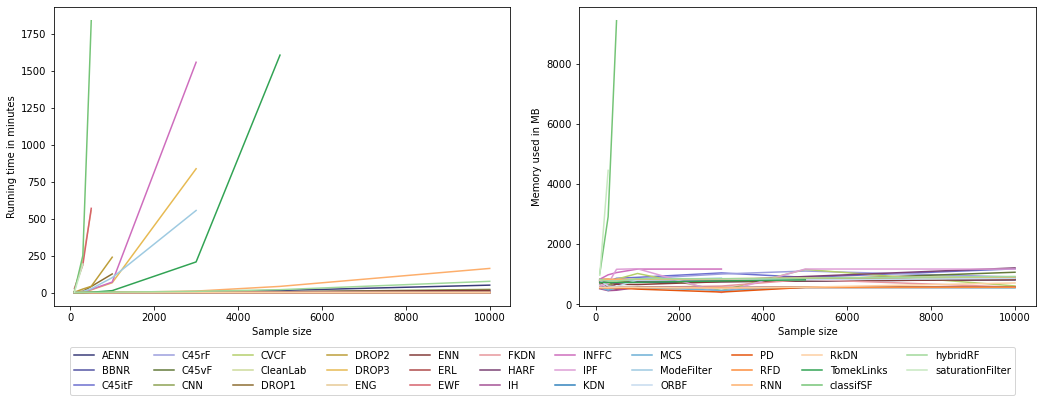

In [274]:
sns.set_palette(sns.color_palette('tab20b')+sns.color_palette('tab20c'))
current_palette = sns.color_palette()

n = 1.1

di = {'s':'Running time in minutes',
     'max_rss':'Memory used in MB'}
models = a['Model'].unique()
fig, axs = plt.subplots(1,2,figsize=(16*n,5*n))

for i, c in enumerate(['s','max_rss']):
    for j, model in enumerate(models[:]):
        temp = a[a['Model']==model][['SampleSize',c,]]#
        axs[i].plot(temp['SampleSize'], temp[c],label = model, color = current_palette[j])
        axs[i].set_ylabel(di[c])
        axs[i].set_xlabel('Sample size')
        
        if i ==1:
            axs[i].legend(bbox_to_anchor=(-0.08, -0.33,0,0), loc='lower center'
                                                          ,borderaxespad=1,
                          fancybox=True, shadow=False, ncol=11)
      #  fig.tight_layout(pad= 0)
    plt.subplots_adjust(hspace = 0.1, wspace =0.15)

    name = 'selection_'+b+'.png'
    plt.savefig('figuresNew/'+name,transparent=False,bbox_inches = 'tight', dpi = 150)





#### Compare the models already used for the analyis and snakemake benchmark

In [333]:
len(models)
# models used for the analysis
models = pd.Series(['ERL', 'AENN', 'IH', 'PD', 'RFD', 'MCS', 'CleanLab', 'KDN', 'RkDN',
       'FKDN', 'C45itF', 'CVCF', 'C45vF', 'IPF', 'C45rF', 'CNN', 'HARF',
       'BBNR', 'ORBF'])
cleanlab = ["CleanLab"]
ERL = ['ERL']
python = ["KDN", "FKDN", "RkDN", "PD", "MCS", "IH", "RFD"]

len(cleanlab)+len(python)+len(ERL)
# not r models
n = cleanlab + python + ERL


r_used = models[~models.isin(n)]
# few r_used models
r_used

1       AENN
10    C45itF
11      CVCF
12     C45vF
13       IPF
14     C45rF
15       CNN
16      HARF
17      BBNR
18      ORBF
dtype: object

In [334]:
# snakemake benchmarked models
models_sn = pd.Series(df['Model'].unique())


In [335]:
# r_all are r filters form snakemake benchmarking
r_all = models_sn[~models_sn.isin(n)]
r_all = r_all.replace(to_replace)

print(r_all.to_list())

['AENN', 'DROP3', 'CNN', 'CVCF', 'C45vF', 'C45rF', 'RNN', 'C45itF', 'ENN', 'INFFC', 'TomekLinks', 'DROP2', 'hybridRF', 'ModeFilter', 'ENG', 'EWF', 'HARF', 'classifSF', 'DROP1', 'BBNR', 'ORBF', 'IPF', 'saturationFilter']


In [337]:
# this is the difference
# are models are having two high running time except for ENN
# run the analysis for ENN!
r_all[~r_all.isin(r_used)]
# ENN? hybridRepairFilter
# add them to the benchmark, ENN also for the final analysis 

3                DROP3
11                 RNN
14                 ENN
15               INFFC
16          TomekLinks
17               DROP2
19            hybridRF
21          ModeFilter
22                 ENG
23                 EWF
25           classifSF
26               DROP1
31    saturationFilter
dtype: object

### Prepare the dataset

In [338]:
to_replace = {'C45votingFilter':'C45vF',
'C45robustFilter':'C45rF',
'C45iteratedVotingFilter':'C45itF',
'ORBoostFilter':'ORBF'}
dfs['Model'] =  dfs['Model'].replace(to_replace)

dfs['Model'].value_counts().index


Index(['ERL', 'AENN', 'IH', 'PD', 'RFD', 'MCS', 'CleanLab', 'RkDN', 'FKDN',
       'KDN', 'C45itF', 'HARF', 'CNN', 'CVCF', 'C45vF', 'BBNR', 'IPF', 'C45rF',
       'ORBF', 'ENN', 'EF', 'GE', 'RNN', 'edgeBoostFilter',
       'hybridRepairFilter', 'ModeFilter', 'INFFC', 'DROP3', 'TomekLinks',
       'PRISM', 'DROP2', 'DROP1', 'EWF', 'ENG', 'saturationFilter',
       'classifSF'],
      dtype='object')

In [340]:
usedModels = dfs['Model'].unique()

# models = [
#     "KDN", "FKDN", "RkDN", "PD", "MCS", "IH", "RFD",
#         'C45rF', 'CVCF', 'C45iF', 'IPF', 
#           'CNN', 'C45vF', 'HARF', 'BBNR', 
#     'ORBF',
#             'AENN',"CleanLab","ERL", "AE" ]
models = ['ERL', 'AENN', 'IH', 'PD', 'RFD', 'MCS', 'CleanLab', 'KDN', 'RkDN',
       'FKDN', 'C45itF', 'CVCF', 'C45vF', 'IPF', 'C45rF', 'CNN', 'HARF',
       'BBNR', 'ORBF', 'ENN']

print(set(usedModels)- set(usedModels).intersection(set(models)))
dfs = dfs[dfs['Model'].isin(models)].reset_index(drop = True)
print(dfs['Model'].unique().shape)



## read in the model file 

mod = pd.read_csv('configs/models.txt',sep = '\t')
groups = ['Similarity','Ensemble','Single']
mod['Abbreviation'] = mod['Abbreviation'].replace(to_replace)

#drop = ['saturationFilter', 'classifSF', 'DROP1', 'DROP2',
#                                 'DROP3', 'EWF', 'TomekLinks','consensusSF','INFFC','ModeFilter', 'ENG','edgeBoostFilter']
#mod = mod[~mod['Abbreviation'].isin(drop)]
mod = mod[mod['Abbreviation'].isin(models)]

di = mod[['Abbreviation','Group']].set_index('Abbreviation').to_dict()['Group']

dfs['Group'] = dfs['Model']
dfs['Group'] = dfs['Group'].replace(di)
print(dfs['Group'].value_counts())


## add the implementaion dictionary for models
repl = {'Tensorflow':'DNN',
'GitHub':'DNN' ,
'Scikit-Clean':'Python',
'NoiseFiltersR':'R'}
mod['Implementation'] = mod['Package'].replace(repl)
repl = mod[['Abbreviation','Implementation']].set_index('Abbreviation').to_dict()['Implementation']




set()
(20,)
Ensemble      171223
Similarity    138673
Single         84910
Name: Group, dtype: int64


### Add new variables

In [347]:
models = dfs['Model'].unique()
len(models)

20

In [348]:
# change for less memory requirements
cols = [ 'True Positive', 'False Positive', 'True Negative',
       'False Negative','DatasetSize','Sample']
dfs[cols] = dfs[cols].astype('int')
cols = ['Precision', 'Recall', 'F-score','NoiseLevel','Execution Time']
dfs[cols] = dfs[cols].astype('float')


## adding new columns
pon = 'Precision over Noise'
dfs[pon] = dfs['Precision']-dfs['NoiseLevel']
dfs['RecallOverNoise'] = dfs['Recall']-dfs['NoiseLevel']
dfs['Accuracy'] =(dfs["True Positive"]+dfs['True Negative'])/dfs['DatasetSize'].astype(int)

#retrieved = 'Retrieved instances'
retrieved = 'Subjective Noise Level'

dfs[retrieved] = (dfs['True Positive'] + dfs['False Positive'])/dfs['DatasetSize'] 


### delete > 10000 FOR NOW
dfs =dfs[dfs['DatasetSize']!=1000000]

cost = 'Cost'
cost1 = 'Cost-mod'


dfs[cost] = dfs['False Positive']/(dfs['True Positive']+dfs['False Negative'])
dfs[cost] = dfs['False Positive']/(dfs['True Positive'])/dfs['NoiseLevel']
dfs[cost] = dfs[retrieved]/dfs['Recall']
dfs[cost1] = dfs[retrieved]/(dfs['Recall']*dfs['NoiseLevel'])


dfs.loc[dfs[cost]==np.inf,cost]=np.nan
dfs.loc[dfs[cost1]==np.inf,cost1]=np.nan



dfs['FPR'] = dfs['False Positive']/(dfs['False Positive']+dfs['True Negative'])
dfs['TPR'] = dfs['True Positive']/(dfs['True Positive']+dfs['False Positive'])

dfs['F-score-mod'] = dfs['F-score']/dfs['NoiseLevel']

dfs['PLR'] = dfs['TPR']/dfs['FPR']
dfs['PLR-Inv'] = dfs['FPR']/dfs['TPR']

for col in [cost, cost1, 'PLR', 'PLR-Inv']:
    dfs.loc[dfs[col]==np.inf,col]=np.nan

    
    

In [349]:
## to have the save proportion of parameters for all models
cols = ['Model','Dataset', 'DatasetSize','NoiseType', 'NoiseLevel']
dfs =  dfs.groupby(cols).sample(n = 10, replace = False,random_state = 1234)
dfs.groupby('Model').count()

Index  Status  True Positive  False Positive  True Negative  \
Model                                                                   
AENN       8400    8400           8400            8400           8400   
BBNR       8400    8400           8400            8400           8400   
C45itF     8400    8400           8400            8400           8400   
C45rF      8400    8400           8400            8400           8400   
C45vF      8400    8400           8400            8400           8400   
CNN        8400    8400           8400            8400           8400   
CVCF       8400    8400           8400            8400           8400   
CleanLab   8400    8400           8400            8400           8400   
ENN        8400    8400           8400            8400           8400   
ERL        8380    8380           8380            8380           8380   
FKDN       8400    8400           8400            8400           8400   
HARF       8400    8400           8400            8400           8400   
IH         8400    8400           8400            8400           8400   
IPF        8400    8400           8400            8400           8400   
KDN        8400    8400           8400            8400           8400   
MCS        8400    8400           8400            8400           8400   
ORBF       8400    8400           8400            8400           8400   
PD         8400    8400           8400            8400           8400   
RFD        8400    8400           8400            8400           8400   
RkDN       8400    8400           8400            8400           8400   

          False Negative  Execution Time  Precision  Recall  F-score  \
Model                                                                  
AENN                8400            8400       8400    8400     8400   
BBNR                8400            8400       8400    8400     8400   
C45itF              8400            8400       8400    8400     8400   
C45rF               8400            8400       8400    8400     8400   
C45vF               8400            8400       8400    8400     8400   
CNN                 8400            8400       8400    8400     8400   
CVCF                8400            8400       8400    8400     8400   
CleanLab            8400            8400       8400    8400     8400   
ENN                 8400            8400       8400    8400     8400   
ERL                 8380            8380       8380    8380     8380   
FKDN                8400            8400       8400    8400     8400   
HARF                8400            8400       8400    8400     8400   
IH                  8400            8400       8400    8400     8400   
IPF                 8400            8400       8400    8400     8400   
KDN                 8400            8400       8400    8400     8400   
MCS                 8400            8400       8400    8400     8400   
ORBF                8400            8400       8400    8400     8400   
PD                  8400            8400       8400    8400     8400   
RFD                 8400            8400       8400    8400     8400   
RkDN                8400            8400       8400    8400     8400   

          Extra Info  Dataset  NoiseLevel  NoiseType  DatasetSize  Sample  \
Model                                                                       
AENN              57     8400        8400       8400         8400    8400   
BBNR              46     8400        8400       8400         8400    8400   
C45itF            52     8400        8400       8400         8400    8400   
C45rF             44     8400        8400       8400         8400    8400   
C45vF             51     8400        8400       8400         8400    8400   
CNN               53     8400        8400       8400         8400    8400   
CVCF              54     8400        8400       8400         8400    8400   
CleanLab          55     8400        8400       8400         8400    8400   
ENN             8400     8400        8400       

In [352]:
dfs = dfs[dfs['NoiseLevel']<=0.5]
#dfs = dfs[dfs['NoiseLevel']>0]

b = 'NoiseMin04'
b = 'NoiseMax05_woClinVar'
#b = 'NoiseAll'

dfs['NoiseLevel'].value_counts()

0.100    28000
0.200    28000
0.300    28000
0.400    28000
0.050    27990
0.500    27990
Name: NoiseLevel, dtype: int64

In [353]:
dfs['Dataset'].value_counts()

Adult        16800
DryBean      16800
HEPMASS      16800
IFD          16800
Magic        16800
RNA0         16800
RNA1         16800
RNA2         16800
Chess        16790
Pokerhand    16790
Name: Dataset, dtype: int64

### Create Latex Tables 

In [362]:
n = round(dfs['Model'].value_counts().mean())
df = pd.DataFrame(dfs[dfs['True Positive']!=0]['Model'].value_counts()/n)
df['Model'] =  (1- df['Model']).abs()
df = df.sort_values('Model',ascending = False)
df['Model'] =df['Model'].mul(100).astype(float).round(2).astype(str).add('%')
df = df.reset_index()

df.columns = ['Model','Ratio']
empty = df.iloc[:11,:].reset_index(drop = True)
empty['Model'] = ''
empty['Ratio'] = ''
df = pd.concat([df.iloc[:11,:].reset_index(drop = True), empty, empty,df.iloc[9:,:].reset_index(drop = True)], axis = 1)

#df.to_latex('tablesNew/ZeroPrecision_'+b+'.tex', index = False)
df

Model   Ratio Model Ratio Model Ratio     Model  Ratio
0     ORBF  49.78%                               IPF  0.18%
1     CVCF   4.08%                                PD  0.11%
2      CNN   3.83%                               MCS  0.08%
3    C45vF   3.12%                          CleanLab  0.06%
4   C45itF   1.38%                              BBNR  0.05%
5     HARF   0.88%                              RkDN  0.04%
6      ERL   0.81%                                IH  0.01%
7    C45rF   0.68%                               ENN  0.01%
8     FKDN   0.48%                              AENN  0.01%
9      IPF   0.18%                               KDN  0.01%
10      PD   0.11%                               RFD   0.0%

In [363]:
df = pd.read_csv('dataProduced/ClinVarTwoLabelsJune23Sample.csv.gz', compression = 'zip',sep = '\t')
#df = df[~df['LabelNew'].str.contains('Conflicting')]
#df = df[~df['LabelOld'].str.contains('Conflicting')]
ct = pd.crosstab(df['LabelOld'], df['LabelNew'], margins = True)
ct = ct.apply(lambda x: '\num{' + x.astype(str)+'}')

#ct.to_latex('tablesNew/ClinvarLabelsCT.tex',escape=False)
ct

/data/gpfs-1/scratch/users/nazaretl_c/tmp/ipykernel_703484/620459994.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('dataProduced/ClinVarTwoLabelsJune23Sample.csv.gz', compression = 'zip',sep = '\t')


LabelNew          Benign    Pathogenic           VUS           All
LabelOld                                                          
Benign      \num{242314}      \num{42}    \num{1918}  \num{244274}
Pathogenic     \num{553}  \num{111338}    \num{4767}  \num{116658}
VUS          \num{22476}    \num{4731}  \num{361240}  \num{388447}
All         \num{265343}  \num{116111}  \num{367925}  \num{749379}

In [365]:
for score in ['Accuracy',pon,'Recall']:
    n = round(len(dfs)*0.7)
    li = []
    for i in range(100):
        dfs_sample = dfs.sample(n = n)
        a = dfs_sample.groupby(['NoiseLevel','Model'])[score].mean().reset_index()
        li.append(a[score])


    a[score] = pd.DataFrame(li).mean(axis = 0)

    a[score] = a[score].apply("{0:.3f}".format)

    a['Value'] = a['Model']+' (' + a[score].astype(str) + ')'

    alle = pd.DataFrame()
    for i in a['NoiseLevel'].unique():
        aa = a[a['NoiseLevel']==i].sort_values(score, ascending = False).reset_index(drop = True).reset_index()
        alle = pd.concat([alle, aa])
    alle = alle.rename(columns = {'index':'Rank'})
    alle = alle.pivot(values = 'Value',columns = 'NoiseLevel', index = 'Rank')#.to_csv('tables/precranks.csv',sep = '\t')
    alle.index = alle.index+1
    alle#.to_latex('tablesNew/Pivot_'+score.replace(' ','')+'_'+b+'.tex', index = True)

In [367]:
# this is not used in the paper
a = dfs[['Precision',pon,'Recall','F-score','NoiseLevel','NoiseType','DatasetSize',retrieved, 
         'PLR','PLR-Inv'  ]]

corr = a.corr().round(3)
corr.round(3)


di = {retrieved:'SNR',
     pon:'PON',
     'NoiseLevel':'Noise level',
     'DatasetSize':'Sample size'}
corr.columns = pd.Series(corr.columns).replace(di)
corr.index = pd.Series(corr.index).replace(di)
corr#.to_latex('tables/Correlation.tex', index = True)

/data/gpfs-1/scratch/users/nazaretl_c/tmp/ipykernel_703484/3189628925.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = a.corr().round(3)


Precision    PON  Recall  F-score  Noise level  Sample size  \
Precision        1.000  0.780   0.276    0.845        0.532        0.037   
PON              0.780  1.000   0.430    0.720       -0.115        0.043   
Recall           0.276  0.430   1.000    0.646       -0.144        0.104   
F-score          0.845  0.720   0.646    1.000        0.367        0.087   
Noise level      0.532 -0.115  -0.144    0.367        1.000        0.000   
Sample size      0.037  0.043   0.104    0.087        0.000        1.000   
SNR             -0.064 -0.288   0.502    0.183        0.288        0.016   
PLR              0.289  0.389   0.083    0.214       -0.041        0.053   
PLR-Inv         -0.126 -0.091  -0.089   -0.130       -0.079        0.015   

               SNR    PLR  PLR-Inv  
Precision   -0.064  0.289   -0.126  
PON         -0.288  0.389   -0.091  
Recall       0.502  0.083   -0.089  
F-score      0.183  0.214   -0.130  
Noise level  0.288 -0.041   -0.079  
Sample size  0.016  0.053    0.015  
SNR          1.000 -0.167    0.097  
PLR         -0.167  1.000   -0.016  
PLR-Inv      0.097 -0.016    1.000

#### Save dataset desciptions into a file


In [ ]:
# dont run
#datasets = ["RNA0", "RNA1", "RNA2"]

#for dataset in datasets[:]:

#df = pd.read_csv('datasets/'+dataset+'.csv.gz',sep = '\t', compression = 'zip')
#    print(dataset, df.shape)
#    print(df.iloc[:,-1].value_counts(normalize = True, sort = False).round(2).to_dict())

### Critical Difference Diagrams (not omptimal, rewrite)

In [18]:
import Orange 
import matplotlib.pyplot as plt


/data/gpfs-1/users/nazaretl_c/work/miniconda/lib/python3.9/site-packages/pyqtgraph/colors/palette.py:1: RuntimeWarning: PyQtGraph supports Qt version >= 5.15, but 5.12.9 detected.
  from ..Qt import QtGui


#### Create and safe the CDD for each score and each group and for all groups together

0.8222471631436485
1.096627158204875
0.428172
2.7066211942014684
0.8222471631436485
1.096627158204875
0.428172
2.7066211942014684


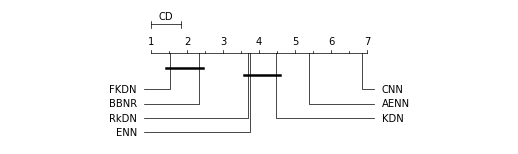

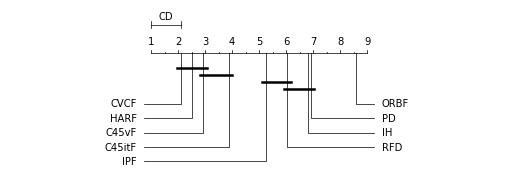

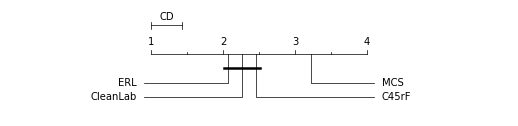

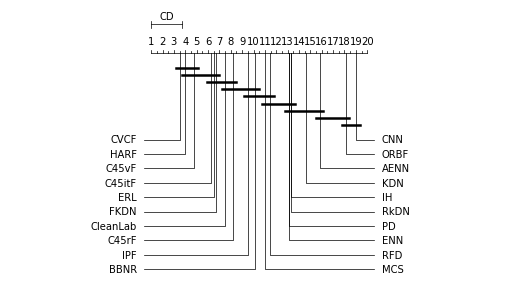

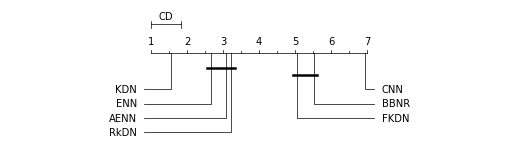

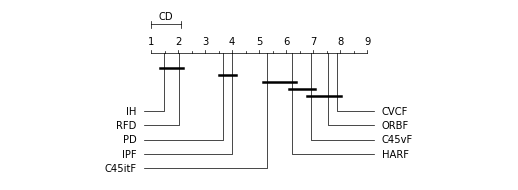

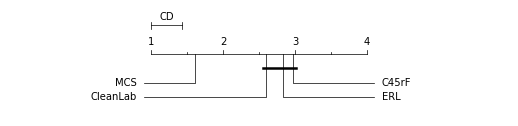

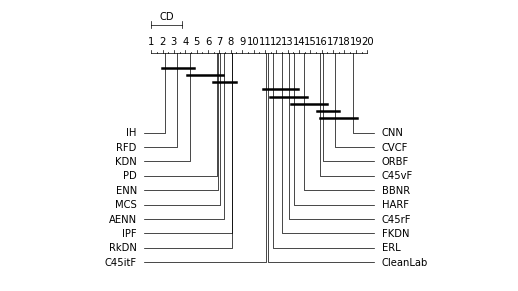

In [22]:
scores = ['Precision','Recall']

#scores = ['Accuracy', 'F-score']

#fig, axs = plt.subplots(3,2,figsize=(16,4*len(score)))

for i, score in enumerate(scores):
    for j,group in enumerate(groups+['All']):
        if group=='All':
            df = dfs#[dfs['Group']  == group]
        else:
            df = dfs[dfs['Group']  == group]
        d = df.pivot_table(values=score, index=['NoiseType','NoiseLevel','Dataset'], columns='Model', aggfunc='mean')
       # d = d.dropna(axis = 1)

        d = d.rank(ascending = False, axis = 1).astype(int)

        names = d.columns.to_list()
        
        avranks = d.mean()
        # First Friedman test (global)  H0: no difference, if rejected 
        # Nemenyi or Bonferroni-Dunn (one-sided, two sided): H0: no difference
        cd = Orange.evaluation.compute_CD(avranks, len(d), alpha='0.05', 
                                         # test="bonferroni-dunn"
                                         )



        Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=7
                                      , textspace=2,  fontsize = 2
                                      # cdmethod=0
                                     )
        name = 'figuresNew/CD'+group+'_'+score+'.png'
        plt.savefig('figuresNew/CD'+group+'_'+score+b+'.png',transparent=True,bbox_inches = 'tight', dpi = 300)


#### Read the saved files for each group separetly 

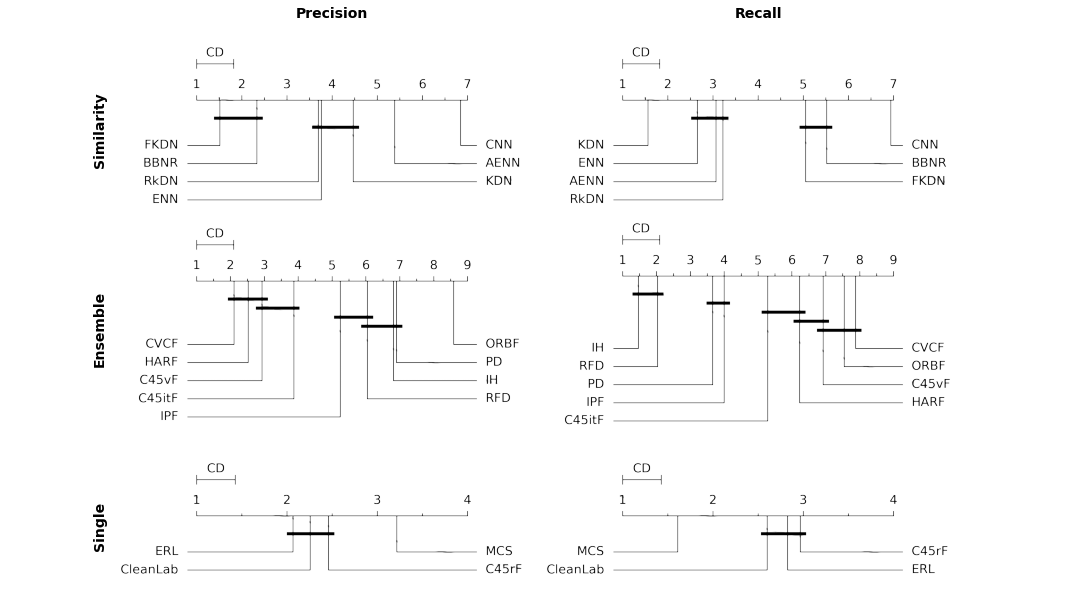

In [23]:
import pickle as pkl
fig, axs = plt.subplots(3,2,figsize=(8,2*len(score)))

for i, score in enumerate(scores):
    for j,group in enumerate(groups):
        

        name = 'figuresNew/CD'+group+'_'+score+b+'.png'
        ax = plt.imread(name)
        axs[j,i].imshow(ax)
        axs[j,i].xaxis.set_visible(False) # same for y axis.
      #  axs[j,i].yaxis.set_visible(False) # same for y axis.
        fig.tight_layout(pad=-25.0)

        axs[j,i].set_frame_on(False)
        if j==0: 
            axs[j,i].set_title("{}".format(score), fontsize = 14, pad=15,weight='bold',style = 'normal',)
        if i==0:
            axs[j,i].set_ylabel(group,style = 'normal',
                                fontsize = 14,labelpad=-100 ,weight='bold'
                               )
        axs[j,i].set_yticks([]) 
plt.savefig('figuresNew/CD'+b+score+'.png',transparent=False,bbox_inches = 'tight', dpi = 150)


In [368]:
#### Read the saved files for all groups together 

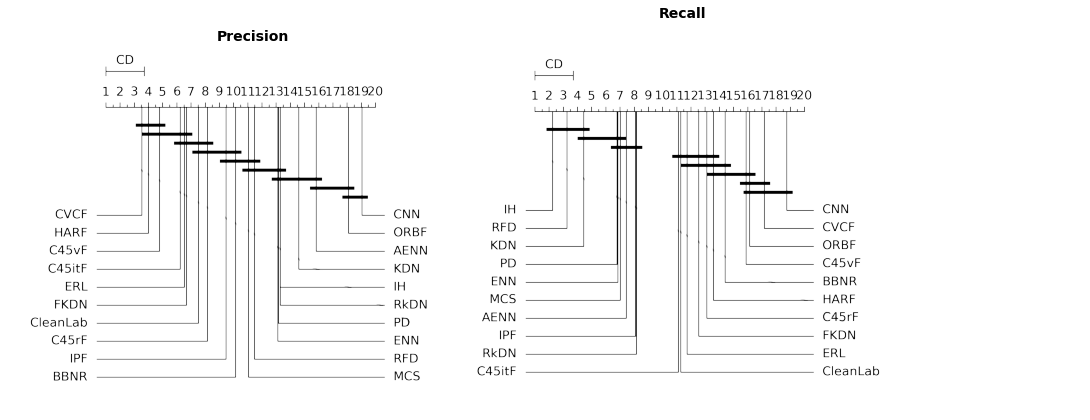

In [24]:
import pickle as pkl
import matplotlib as mpl

fig, axs = plt.subplots(1,2,figsize=(8,2.5*len(score)))
group = 'All'
coordinatesList = [[-300, 0], [-300, 0]]

for i, score in enumerate(scores):        

        name = 'figuresNew/CD'+group+'_'+score+b+'.png'
        ax = plt.imread(name)
        imgplot = axs[i].imshow(ax)
#        axs[i].xaxis.set_visible(False) # same for y axis.
      #  axs[j,i].yaxis.set_visible(False) # same for y axis.
        fig.tight_layout(pad=-25.0)

        axs[i].set_frame_on(False)
       # if i==0: 
        if score=='Recall':
            pad = 27
        else:
            pad =0
        axs[i].set_title("{}".format(score), fontsize = 14, pad=pad
                         ,weight='bold',style = 'normal',
                        x=0.38, y=1, 
                        # loc = 'center'
                        )
        tx, ty = coordinatesList[i]
        transform = mpl.transforms.Affine2D().translate(tx, ty)
        imgplot.set_transform(transform + axs[i].transData)

      
        axs[i].set_xticks([]) 
        axs[i].set_yticks([]) 

plt.savefig('figuresNew/CD_All'+b+score+'.png',transparent=False,bbox_inches = 'tight', dpi = 150)


### Main Analysis (plots)

In [369]:
labels = {'NoiseLevel': 'Noise level',
         'DatasetSize' : 'Sample size'}
fs = 10

In [370]:
dfs['Dataset'].value_counts()

Adult        16800
DryBean      16800
HEPMASS      16800
IFD          16800
Magic        16800
RNA0         16800
RNA1         16800
RNA2         16800
Chess        16790
Pokerhand    16790
Name: Dataset, dtype: int64

#### Figure 3. Precision, recall and F-score for different datasets over all parameters.

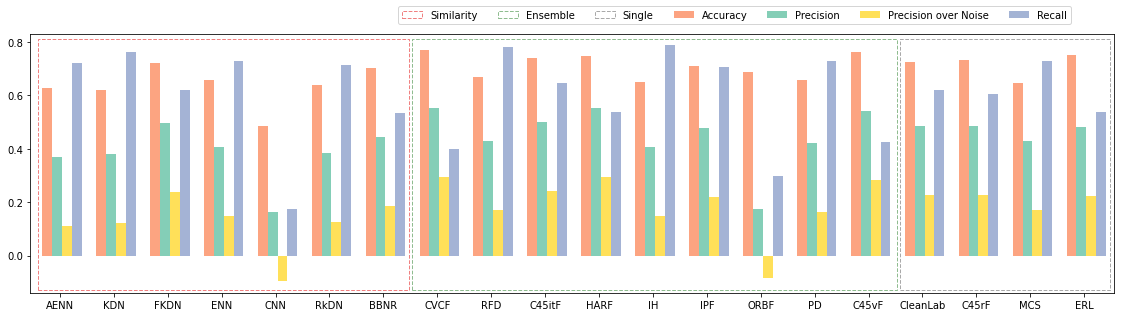

In [371]:

df =  dfs.groupby(['Model'])[['Precision','Recall','F-score','Accuracy',pon]].mean()#.dropna(how = 'all')


di = dict(dfs[['Model','Group']].value_counts().index)
diSave = di
di1 = {'Ensemble':1,'Similarity':0,'Single':2}



df['Group'] = df.index
df['Group'] = df['Group'].replace(di).replace(di1).astype(int)
df = df.sort_values('Group')
di2 = df['Group'].value_counts()
colors  = pd.Series(sns.color_palette("Set2"))[[0,1,2,5]]
fig = plt.figure(figsize=(16,4.5 ))


colors = list(set(colors))
ax = fig.add_subplot(111)
indices = np.array(list(range(len(df))))
width = np.min(np.diff(indices))/3 -0.15

# matplotlib 3.0 you have to use align
s =0.005

ax.bar(indices-width+s,df['Accuracy'],width,align='edge',
       label = 'Accuracy' ,alpha = 0.8, color = colors[2]
      )

ax.bar(indices+s,df['Precision'],width,align='edge',
       label = 'Precision',color = colors[1]
       ,alpha = 0.8 )


ax.bar(indices+width+s,df[pon],width,align='edge',alpha = 0.8,
       label = pon,color = colors[0]
      )
ax.bar(indices+width*2+s,df['Recall'],width,align='edge',alpha = 0.8,
       label = 'Recall',color = colors[3]
      )


plt.xticks(indices+0.15, df.index.to_list(), fontsize = fs,rotation=0)
plt.yticks(fontsize = fs)



ax.add_patch(plt.Rectangle((0.007, 0.01), .343, 0.97, ls="--", ec="lightcoral", fc="none", 
    transform=ax.transAxes, label = 'Similarity'))

ax.add_patch(plt.Rectangle((.352, 0.01), .448, 0.97, ls="--", ec="darkseagreen", 
                           fc="none",
                           transform=ax.transAxes, label = 'Ensemble'))

ax.add_patch(plt.Rectangle((0.803, 0.01), .193, 0.97, ls="--", ec="darkgrey", 
                           fc="none",
                           transform=ax.transAxes, label = 'Single'))

#fig.legend(#)
plt.legend(ncol = 7, fontsize = fs, loc='center', bbox_to_anchor=(0.65, 1.07))

plt.xlim([-0.4,len(indices)-0.3])
    
fig.tight_layout()

name = 'BarPlotAll'+b+'.png'    
#plt.savefig('figuresNew/'+ name,transparent=False,bbox_inches = 'tight', dpi = 150)

plt.show()

#### Line plots with vertical alignment of groups

16.0
16.0


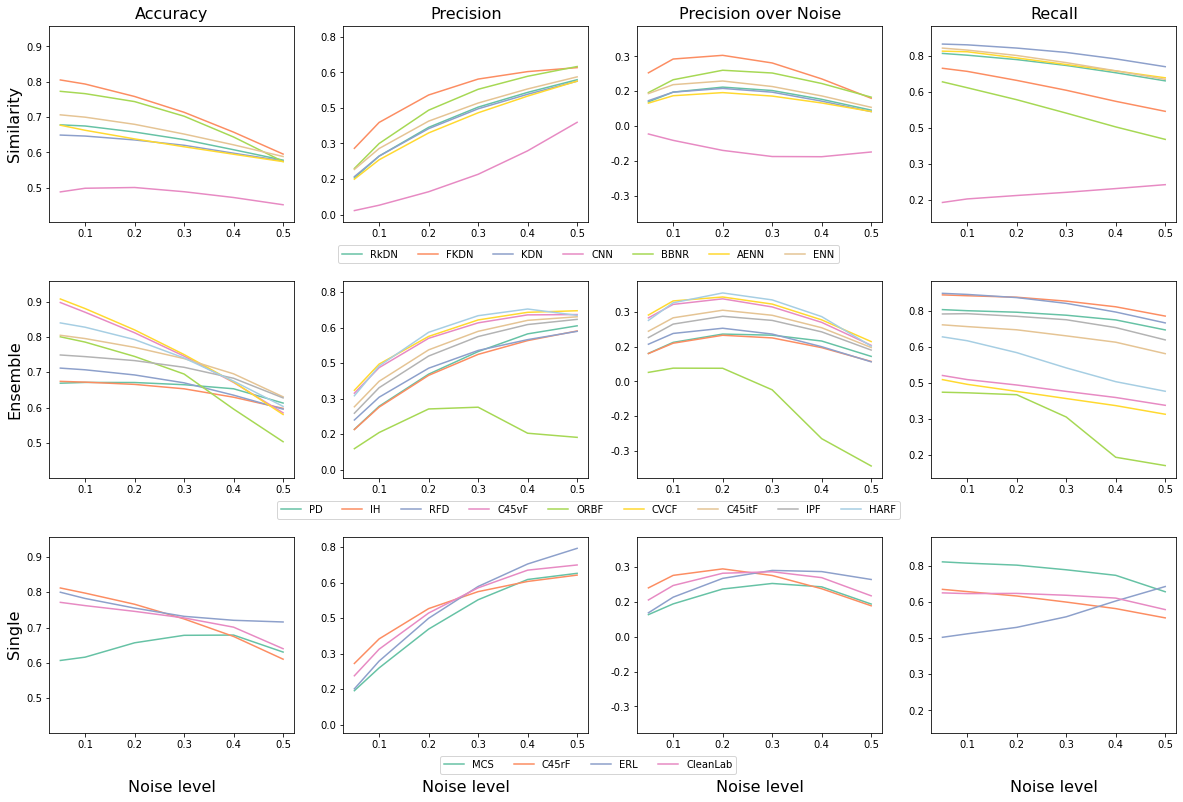

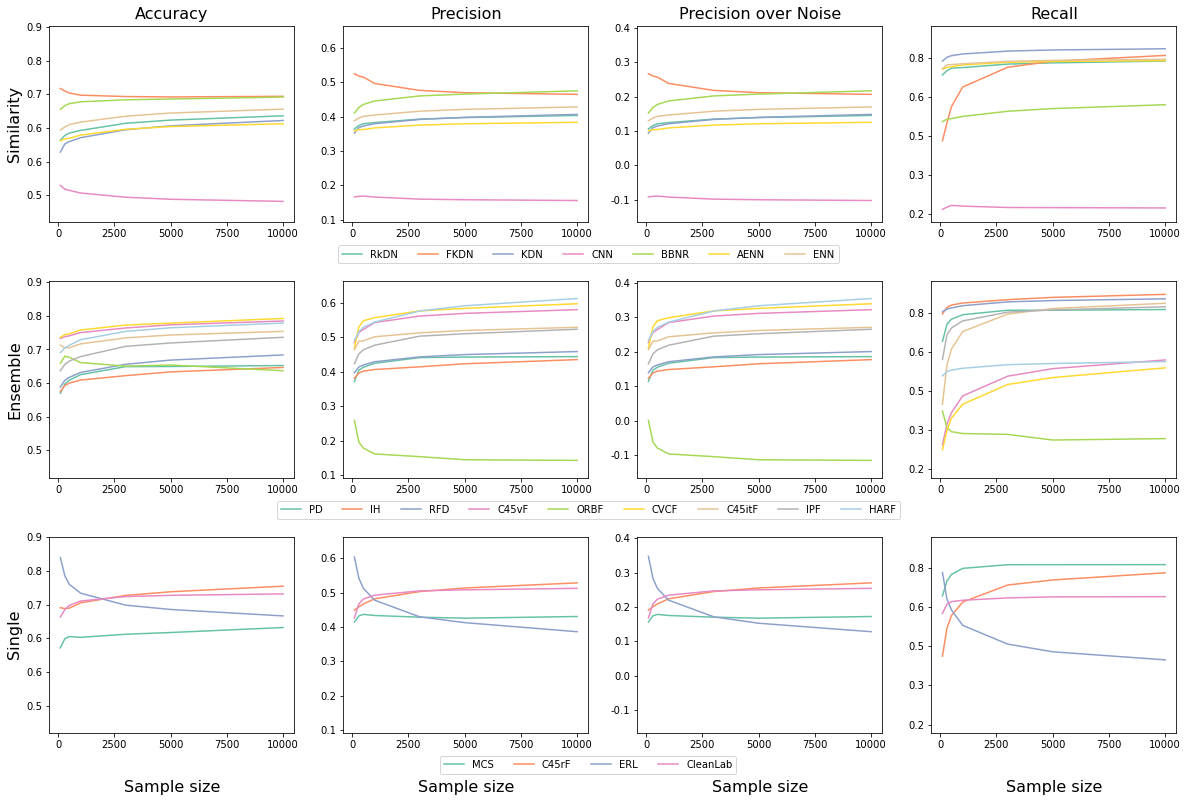

In [372]:
## Performance wrt to particular model 


allScores = dfs
di = {
#     'PrecisionOverNoise':[['Precision', pon, pon], ['NoiseLevel','NoiseLevel','DatasetSize'], True], #Figure 7
#      'RecallOverNoise':[['Recall', 'Recall'], ['NoiseLevel','DatasetSize'], True], # Figure 8
#          'AccuracyOverNoise':[['Accuracy', 'Accuracy'], ['NoiseLevel','DatasetSize'], True], # Figure 8

#      'CostOfTP' : [[retrieved,'PLR-Inv' ], ['NoiseLevel','NoiseLevel'], True], # Figure 10
#       'ExecutionTime' : [['Execution Time','Execution Time'],['NoiseLevel','DatasetSize'], False],
#    # 'CostComparison' : [[retrieved, 'F-score','F-score-mod', 'Cost','Cost-mod','PLR','PLR-Inv'], ['NoiseLevel']*7, True],
#    #'AllMetricsOverNoise' : [['Precision', pon,'Recall', 'Accuracy'], ['NoiseLevel']*4, True]

    'AllOverNoise':[['Accuracy','Precision', pon, 'Recall'], ['NoiseLevel','NoiseLevel','NoiseLevel','NoiseLevel'], True], #Figure 7
     'AllOverSampleSize':[['Accuracy','Precision', pon, 'Recall'], ['DatasetSize','DatasetSize','DatasetSize','DatasetSize'], True], # Figure 8
    #     'AccuracyOverNoise':[['Accuracy', 'Accuracy'], ['NoiseLevel','DatasetSize'], True], # Figure 8

  #   'CostOfTP' : [[retrieved,'PLR-Inv' ], ['NoiseLevel','NoiseLevel'], True], # Figure 10
  #    'ExecutionTime' : [['Execution Time','Execution Time'],['NoiseLevel','DatasetSize'], False],
   # 'CostComparison' : [[retrieved, 'F-score','F-score-mod', 'Cost','Cost-mod','PLR','PLR-Inv'], ['NoiseLevel']*7, True],
   #'AllMetricsOverNoise' : [['Precision', pon,'Recall', 'Accuracy'], ['NoiseLevel']*4, True]

     }


n = 1.3
fontsize = 10

for key in di.keys():

    li = di[key][0]
    variables = di[key][1]
    fig, axs = plt.subplots(3,len(li),figsize=(3.5*len(li)*n+2,10*n))

    for i,Score in enumerate(li):

        scores = allScores
        variable = variables[i]
        label = labels[variable]
        lim = scores.groupby(['Model', variable])[Score].mean()
        if (key=='CostOfTP')& (Score=='PLR-Inv'):
            lim = pd.Series([0,scores.groupby(['Model', variable])[Score].mean().sort_values(ascending = False)[3]+0.5])
        applyLim = di[key][2]
        for j,group in enumerate(groups):  
                models = mod[mod['Group']==group]['Abbreviation']

                for model in models[:]:
                    table_ = scores[scores['Model'] == model]

                    if len(table_) > 0:

                        table = pd.DataFrame(table_.groupby(variable).mean(numeric_only = True)).reset_index()
                        table_ = table.sort_values([variable])

                        axs[j,i].plot(table[variable],table[Score].astype(float),  label = model)
                        if j==len(groups)-1: 
                            axs[j,i].set_xlabel(label,fontsize = 16, labelpad=30)

                        if j==0: 
                            axs[j,i].set_title("{}".format(Score), fontsize = 16, pad=7)
                        if i==0:
                            axs[j,i].set_ylabel(group,fontsize = 16 )
#                            
                            leg = axs[j,i].legend(bbox_to_anchor=(2.2, -0.26,0,0), loc='lower center'
                                                  ,borderaxespad=1,
                  fancybox=True, shadow=False, ncol=10)
                   

                        axs[j,i].set_ylim(lim.min()-0.05,lim.max()+0.05)
                        if lim.mean()>1:
                            f = '%.0f'
                        else:
                            f = '%.1f'
                        axs[j,i].yaxis.set_major_formatter(FormatStrFormatter(f))
                        axs[j,i].yaxis.set_major_locator(MaxNLocator(6)) 
                        axs[j,i].xaxis.set_major_locator(MaxNLocator(5)) 

    plt.subplots_adjust(hspace = 0.3, wspace =0.2)

    name = key+b+'.png'
  #  plt.savefig('figuresNew/'+name,transparent=False,bbox_inches = 'tight', dpi = 150)



#### Line plots with horuzontal alignment of groups

9.0


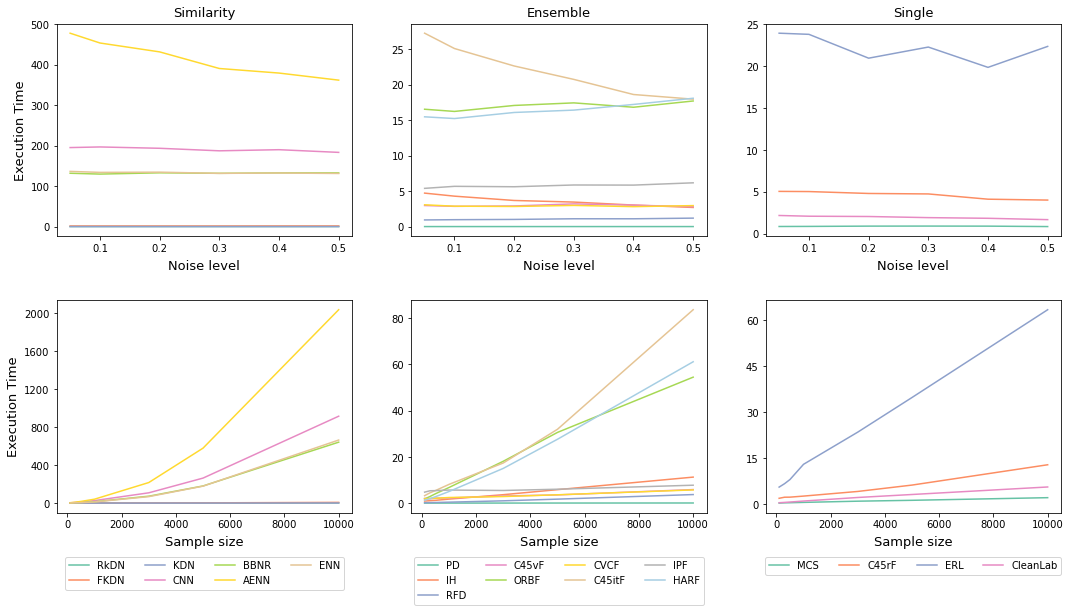

In [373]:


allScores = dfs
di = {
#     'PrecisionOverNoise':[['Precision', pon, pon], ['NoiseLevel','NoiseLevel','DatasetSize'], True], #Figure 7
#      'RecallOverNoise':[['Recall', 'Recall'], ['NoiseLevel','DatasetSize'], True], # Figure 8
#          'AccuracyOverNoise':[['Accuracy', 'Accuracy'], ['NoiseLevel','DatasetSize'], True], # Figure 8

#      'CostOfTP' : [[retrieved,'PLR-Inv' ], ['NoiseLevel','NoiseLevel'], True], # Figure 10
#       'ExecutionTime' : [['Execution Time','Execution Time'],['NoiseLevel','DatasetSize'], False],
#    # 'CostComparison' : [[retrieved, 'F-score','F-score-mod', 'Cost','Cost-mod','PLR','PLR-Inv'], ['NoiseLevel']*7, True],
#    #'AllMetricsOverNoise' : [['Precision', pon,'Recall', 'Accuracy'], ['NoiseLevel']*4, True]

 #   'AllOverNoise':[['Accuracy','Precision', pon, 'Recall'], ['NoiseLevel','NoiseLevel','NoiseLevel','NoiseLevel'], True], #Figure 7
  #   'AllOverSampleSize':[['Accuracy','Precision', pon, 'Recall'], ['DatasetSize','DatasetSize','DatasetSize','DatasetSize'], True], # Figure 8
    #     'AccuracyOverNoise':[['Accuracy', 'Accuracy'], ['NoiseLevel','DatasetSize'], True], # Figure 8

  #   'CostOfTP' : [[retrieved,'PLR-Inv' ], ['NoiseLevel','NoiseLevel'], True], # Figure 10
      'ExecutionTime' : [['Execution Time','Execution Time'],['NoiseLevel','DatasetSize'], False],
   # 'CostComparison' : [[retrieved, 'F-score','F-score-mod', 'Cost','Cost-mod','PLR','PLR-Inv'], ['NoiseLevel']*7, True],
   #'AllMetricsOverNoise' : [['Precision', pon,'Recall', 'Accuracy'], ['NoiseLevel']*4, True]  
     }


n = 1.5
fontsize = 10

for key in di.keys():

    li = di[key][0]
    variables = di[key][1]
    fig, axs = plt.subplots(len(li),3,figsize=(12*n,3*len(li)*n))
    
    for j,Score in enumerate(li):

        scores = allScores
        variable = variables[j]
        label = labels[variable]
        lim = scores.groupby(['Model', variable])[Score].mean()
        if (key=='CostOfTP')& (Score=='PLR-Inv'):
            lim = pd.Series([0,scores.groupby(['Model', variable])[Score].mean().sort_values(ascending = False)[3]+0.5])
        applyLim = di[key][2]
        for i,group in enumerate(groups):  
                models = mod[mod['Group']==group]['Abbreviation']

                for model in models[:]:
                    table_ = scores[scores['Model'] == model]

                    if len(table_) > 0:

                        table = pd.DataFrame(table_.groupby(variable).mean(numeric_only = True)).reset_index()
                        table_ = table.sort_values([variable])

                        axs[j,i].plot(table[variable],table[Score].astype(float),  label = model)
                        axs[j,i].set_xlabel(label,fontsize = 13, labelpad=6)


                        if j==len(li)-1: 
                            axs[j,i].legend(bbox_to_anchor=(0.5, -0.16), loc='upper center'
                                                  ,borderaxespad=1,
                  fancybox=True, shadow=False, ncol=4)

                        if j==0: 
                            axs[j,i].set_title("{}".format(group), fontsize = 13, pad=7)
                          
                        if i==0:
                            axs[j,i].set_ylabel(Score,fontsize = 13 )

                        if lim.mean()>1:
                            f = '%.0f'
                        else:
                            f = '%.1f'
                        axs[j,i].yaxis.set_major_formatter(FormatStrFormatter(f))
                        axs[j,i].yaxis.set_major_locator(MaxNLocator(6)) 
                     
                        locs, l = plt.xticks() 

                    
    plt.subplots_adjust(hspace = 0.3, wspace =0.2)

    name = key+b+'.png'
  #  plt.savefig('figuresNew/'+name,transparent=False,bbox_inches = 'tight', dpi = 150)



#### Model performance on different datasets (vertical plots)

40.5


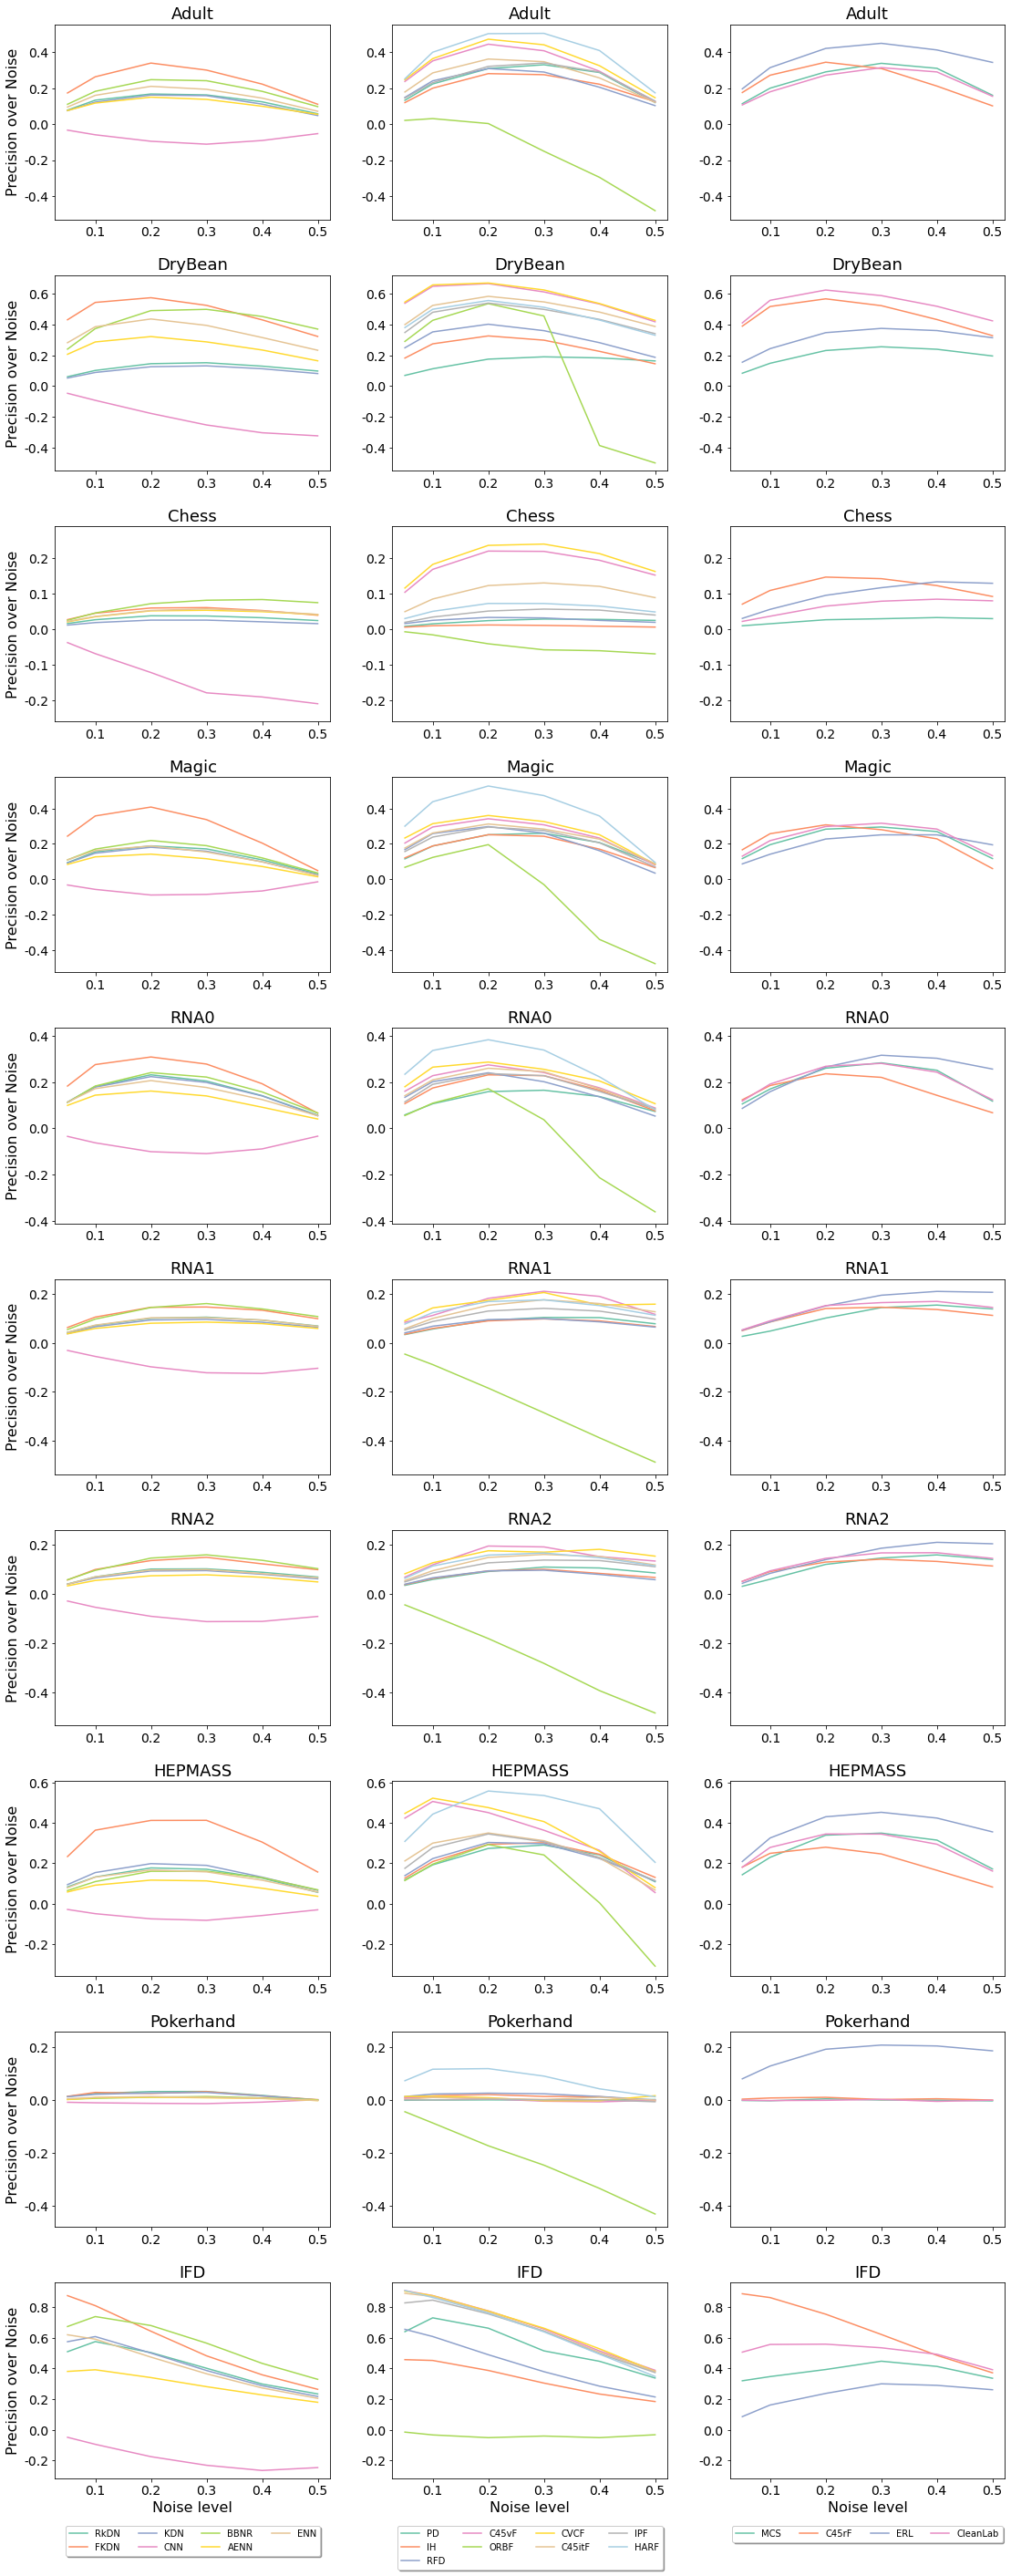

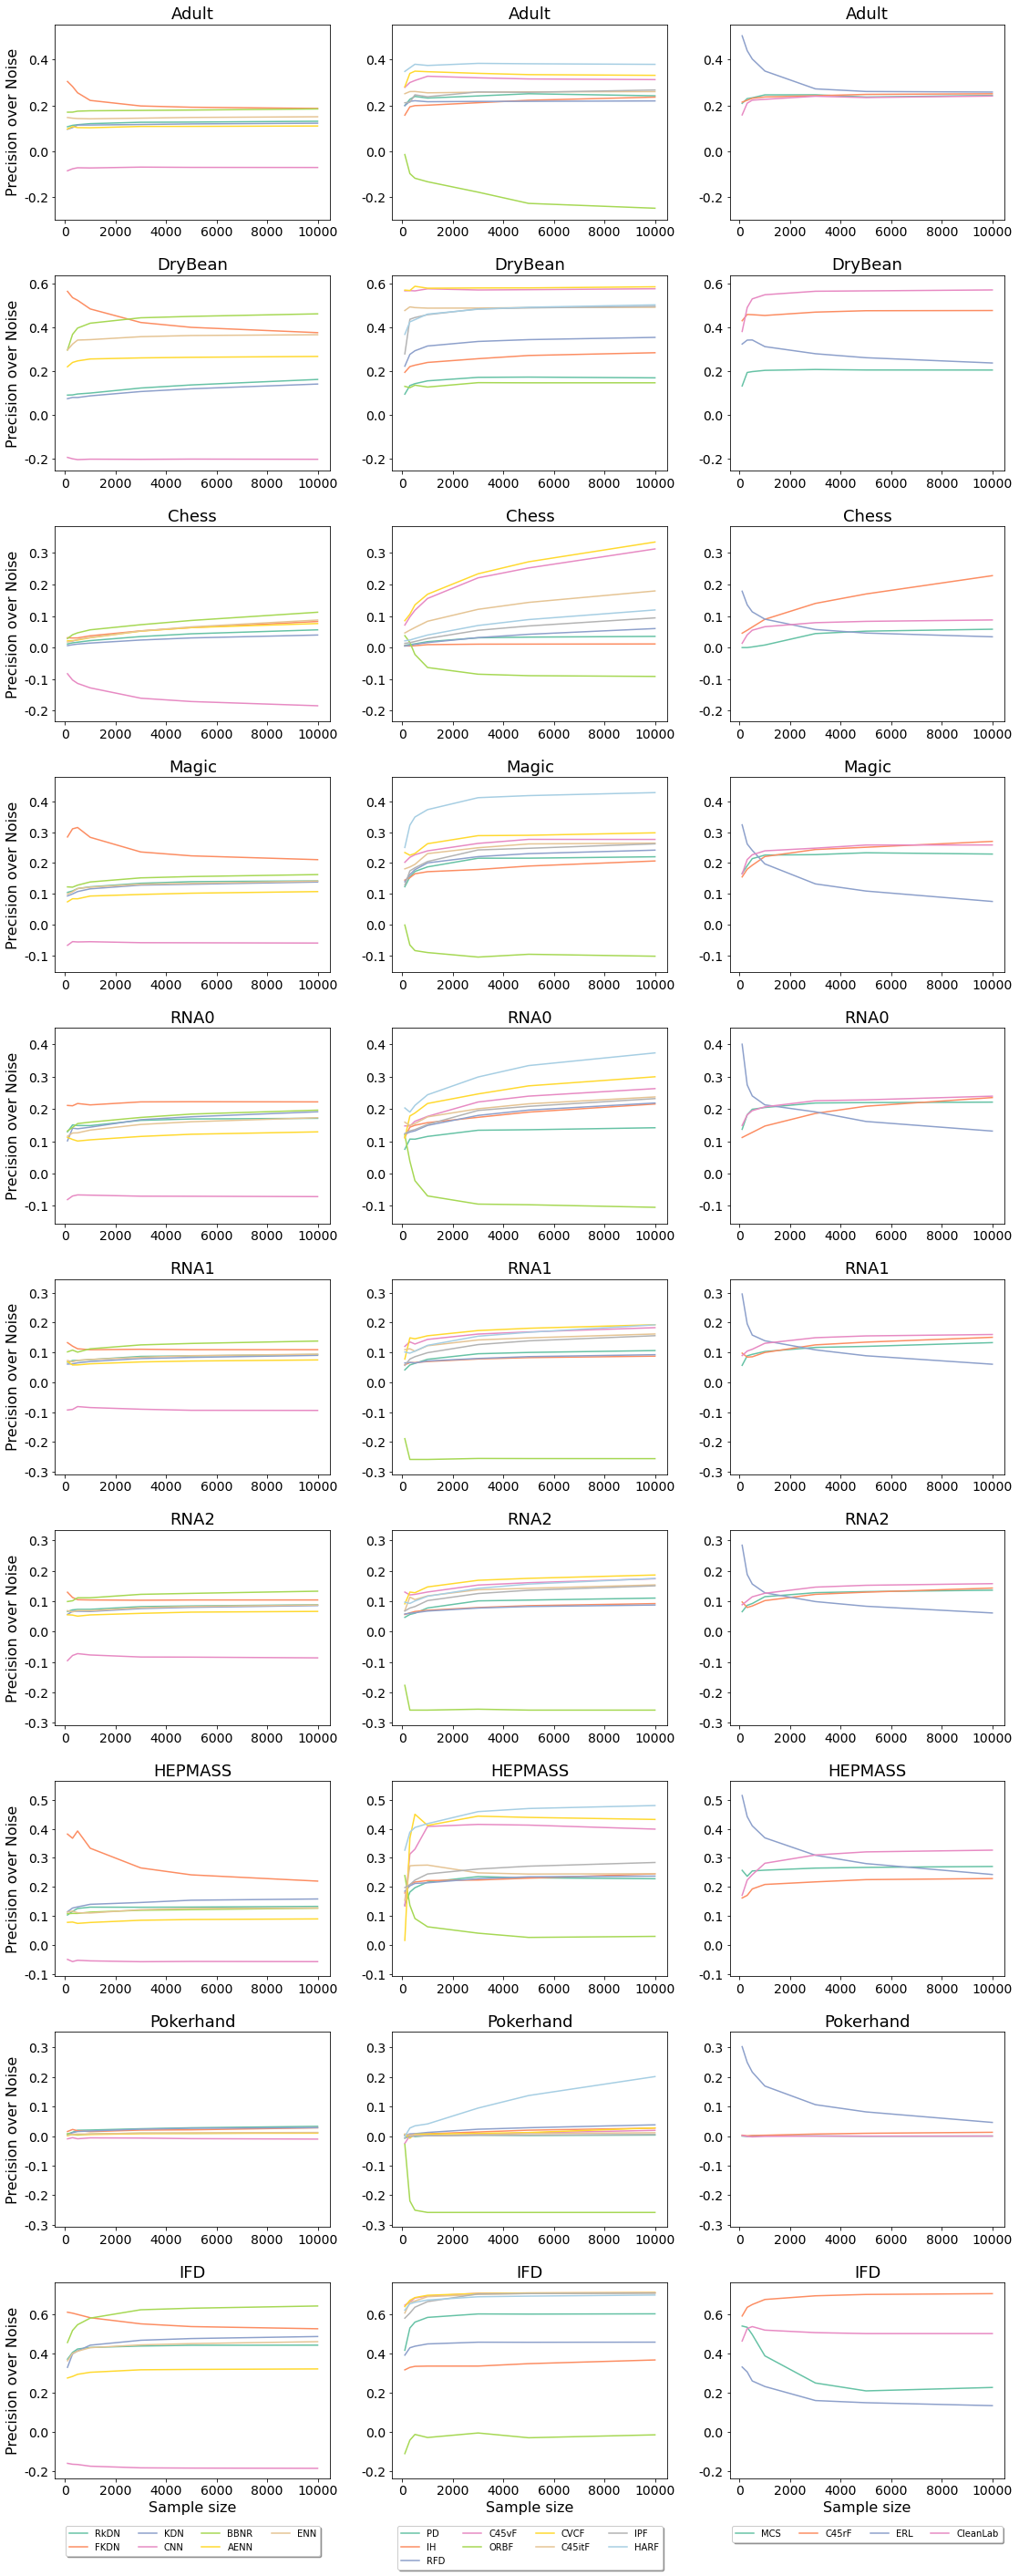

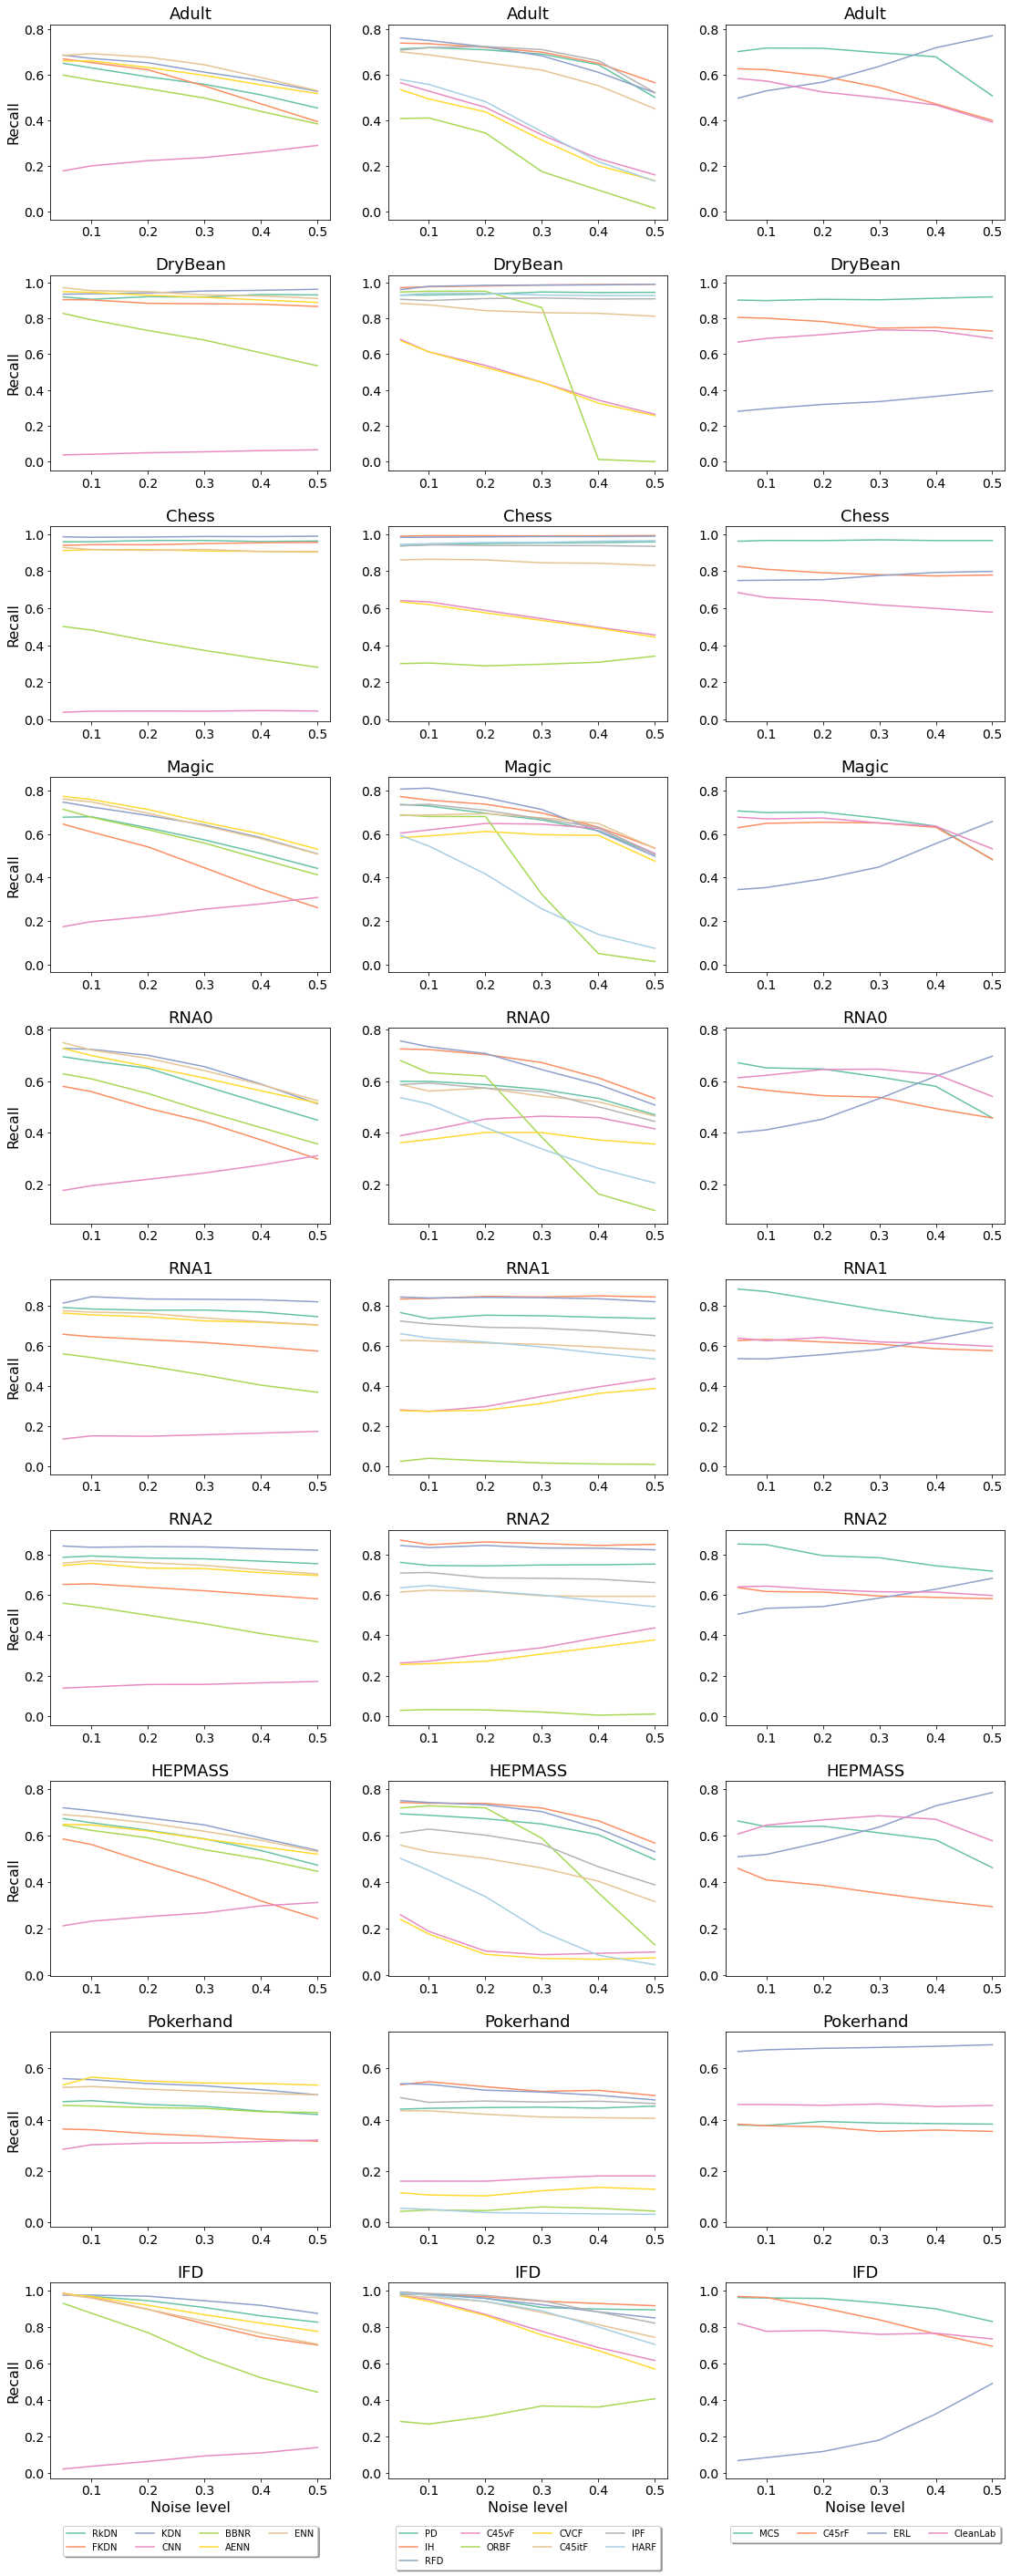

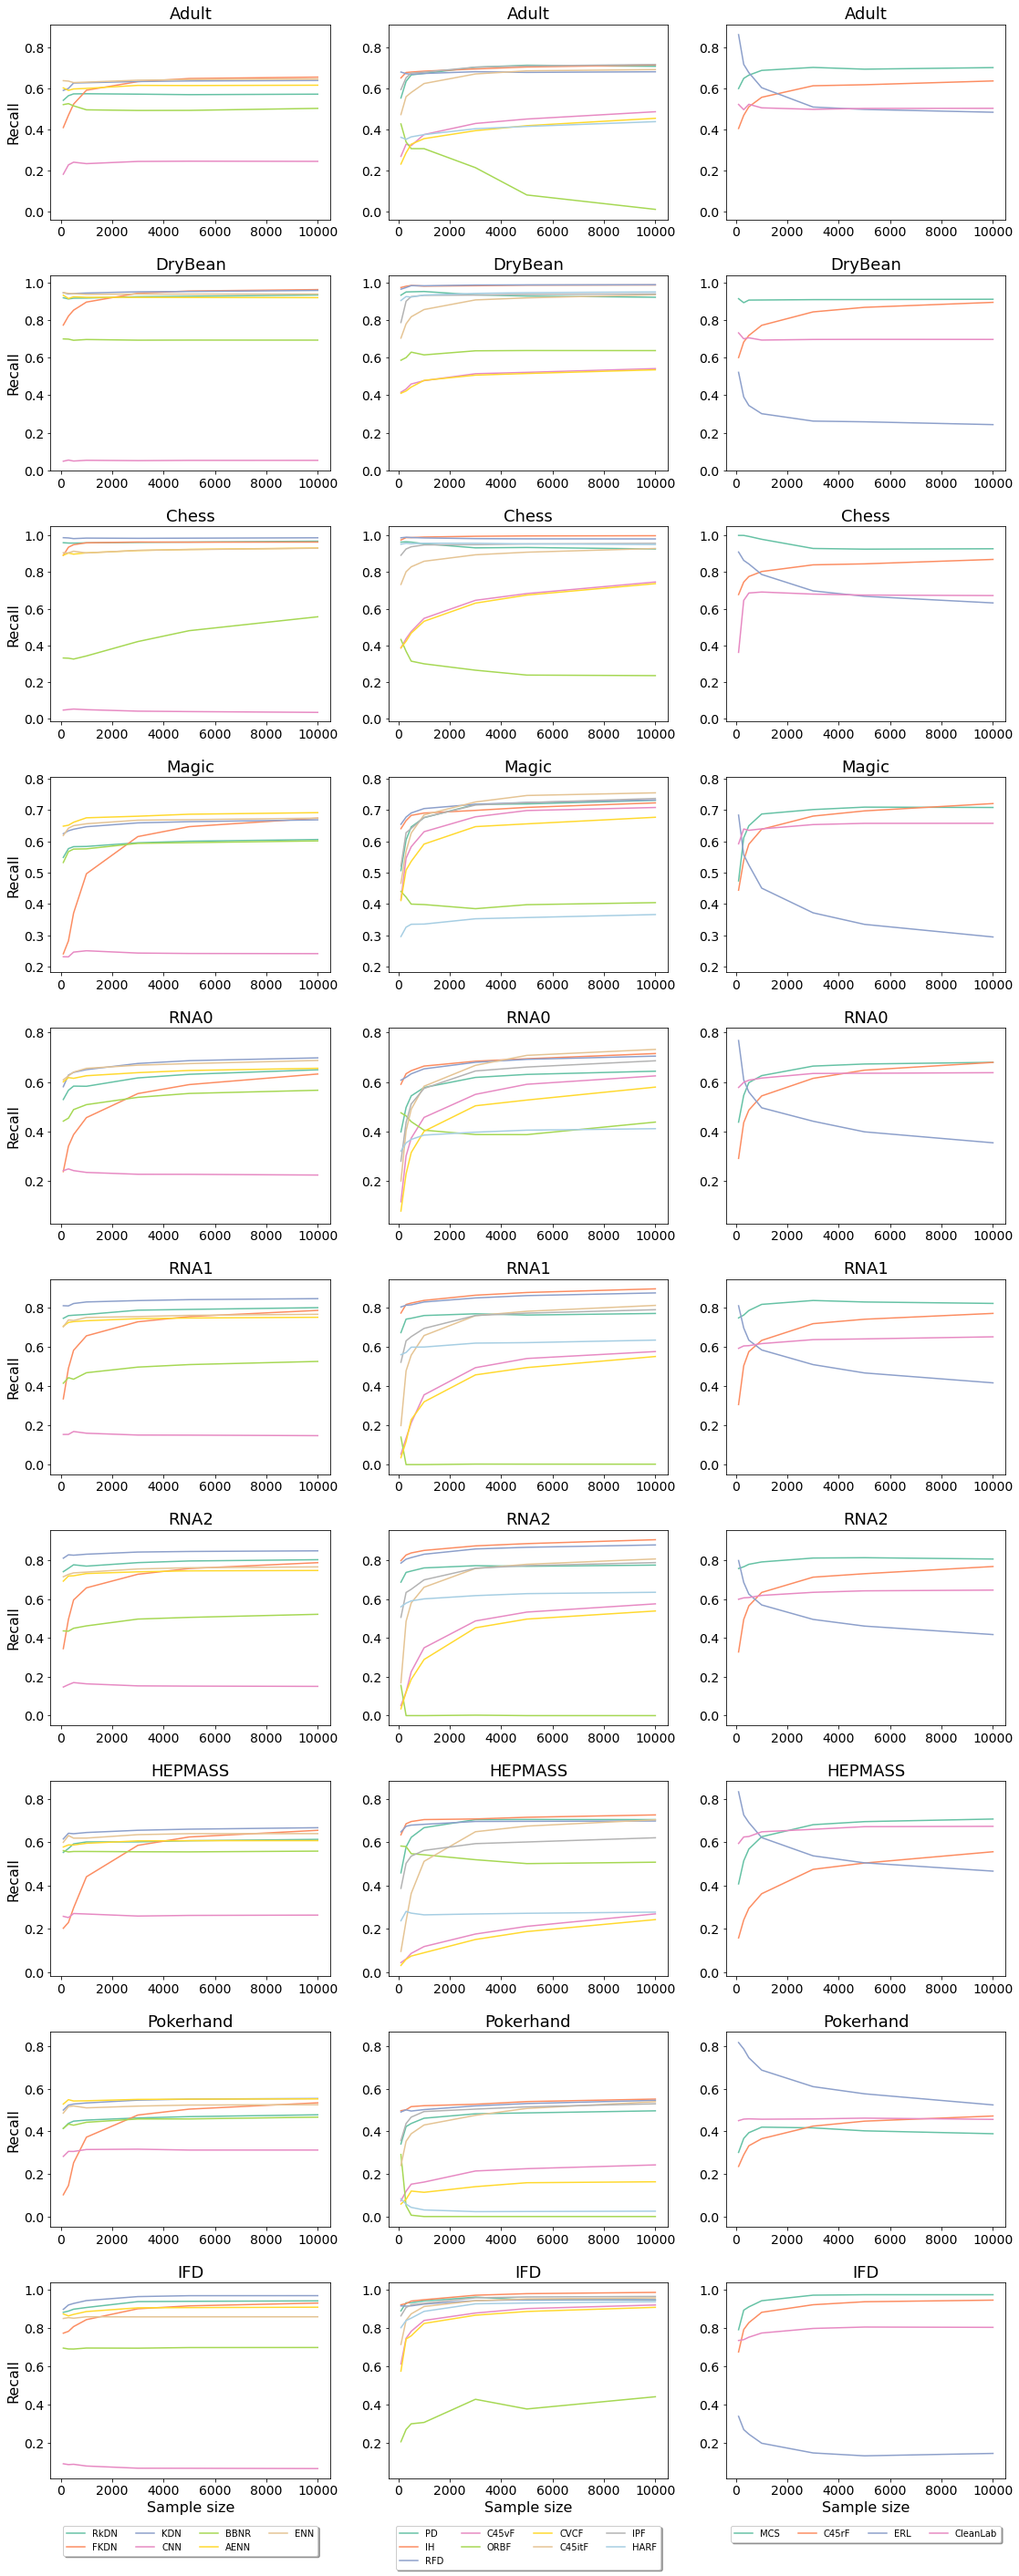

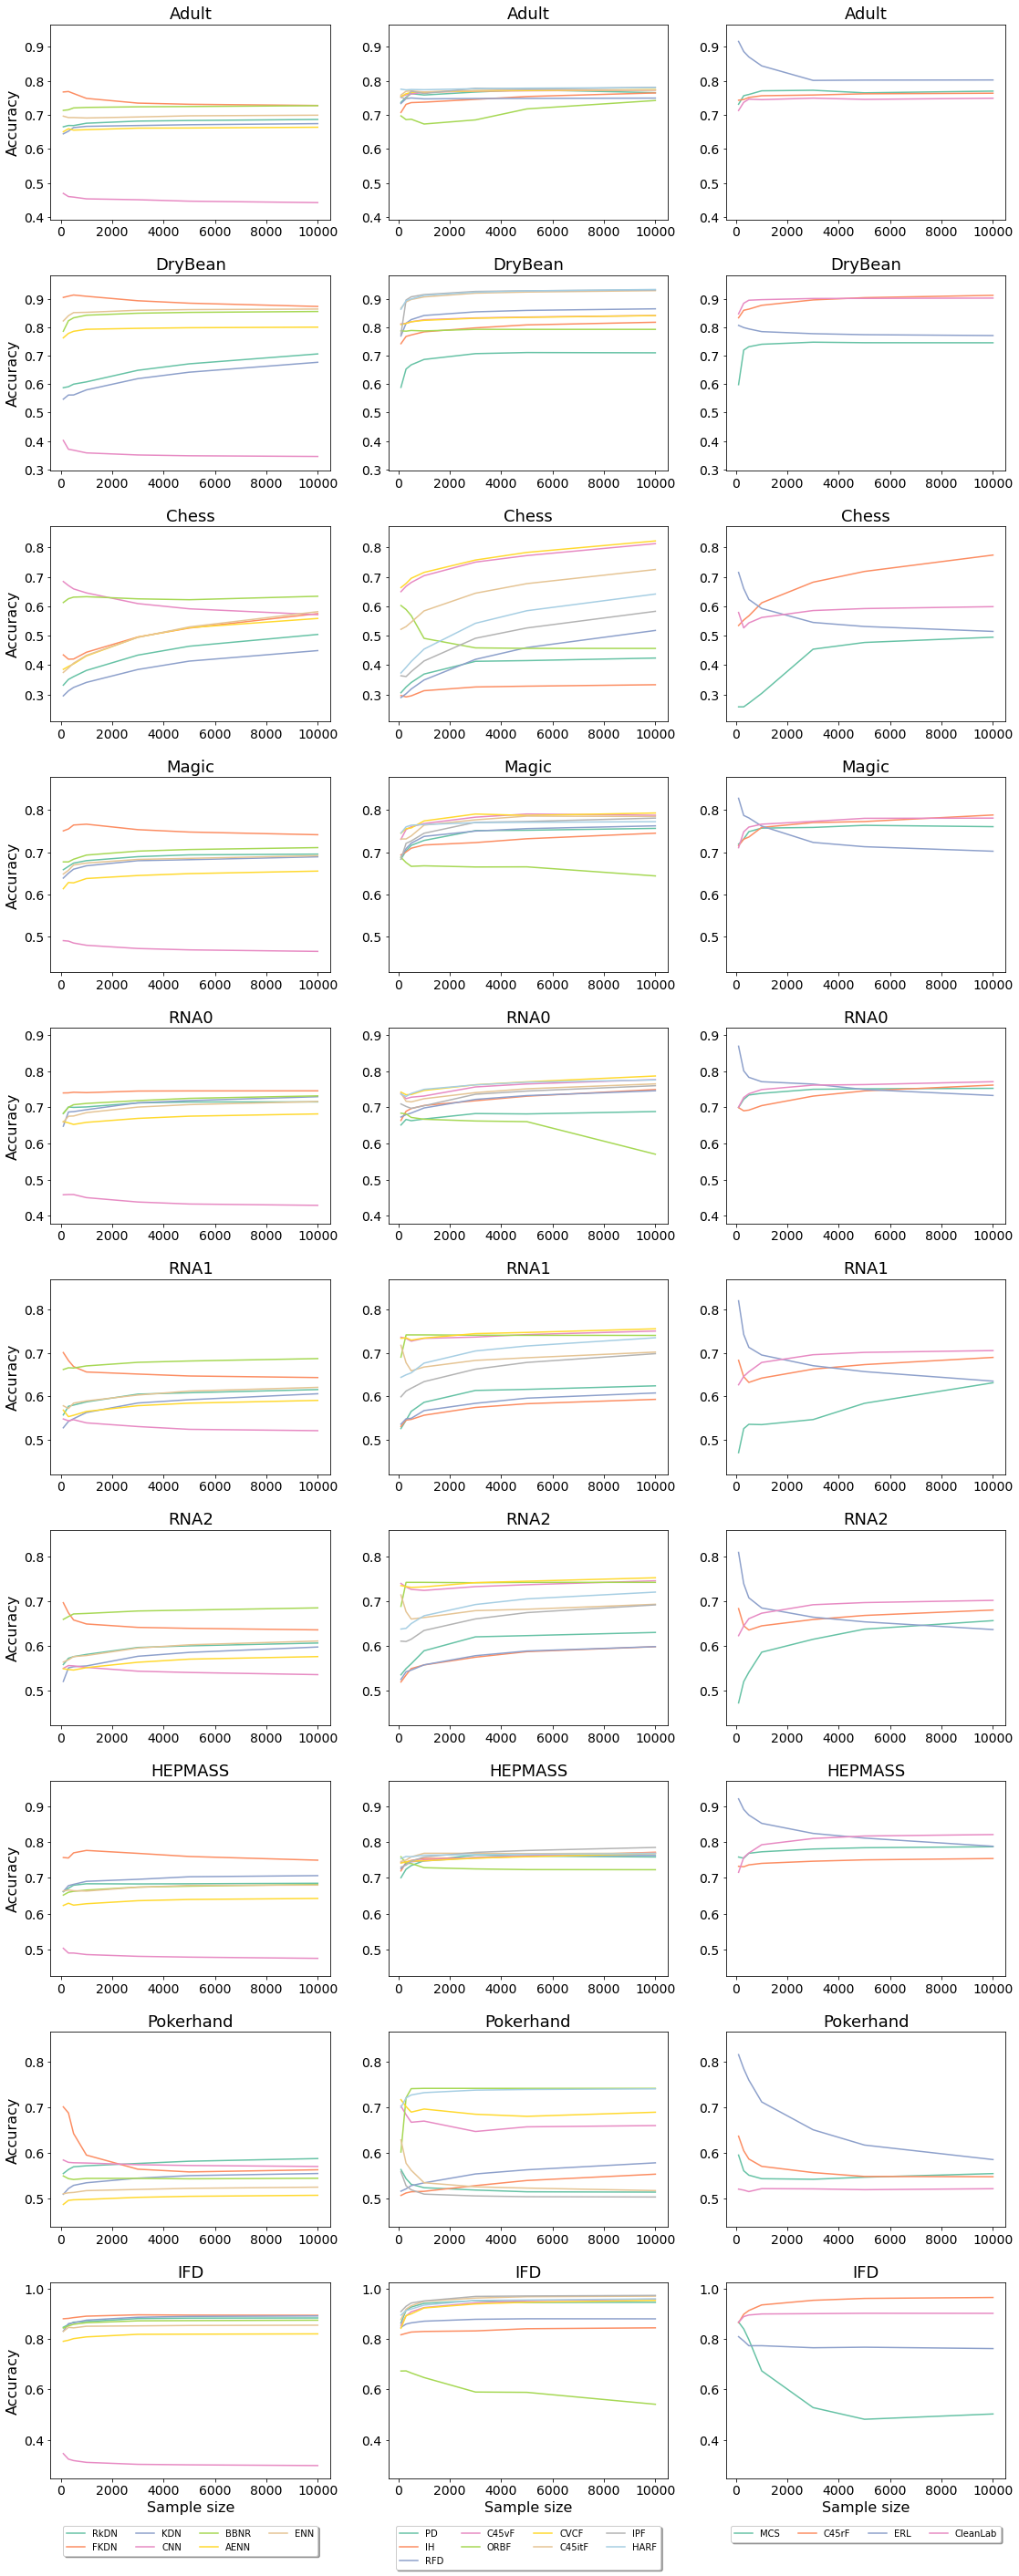

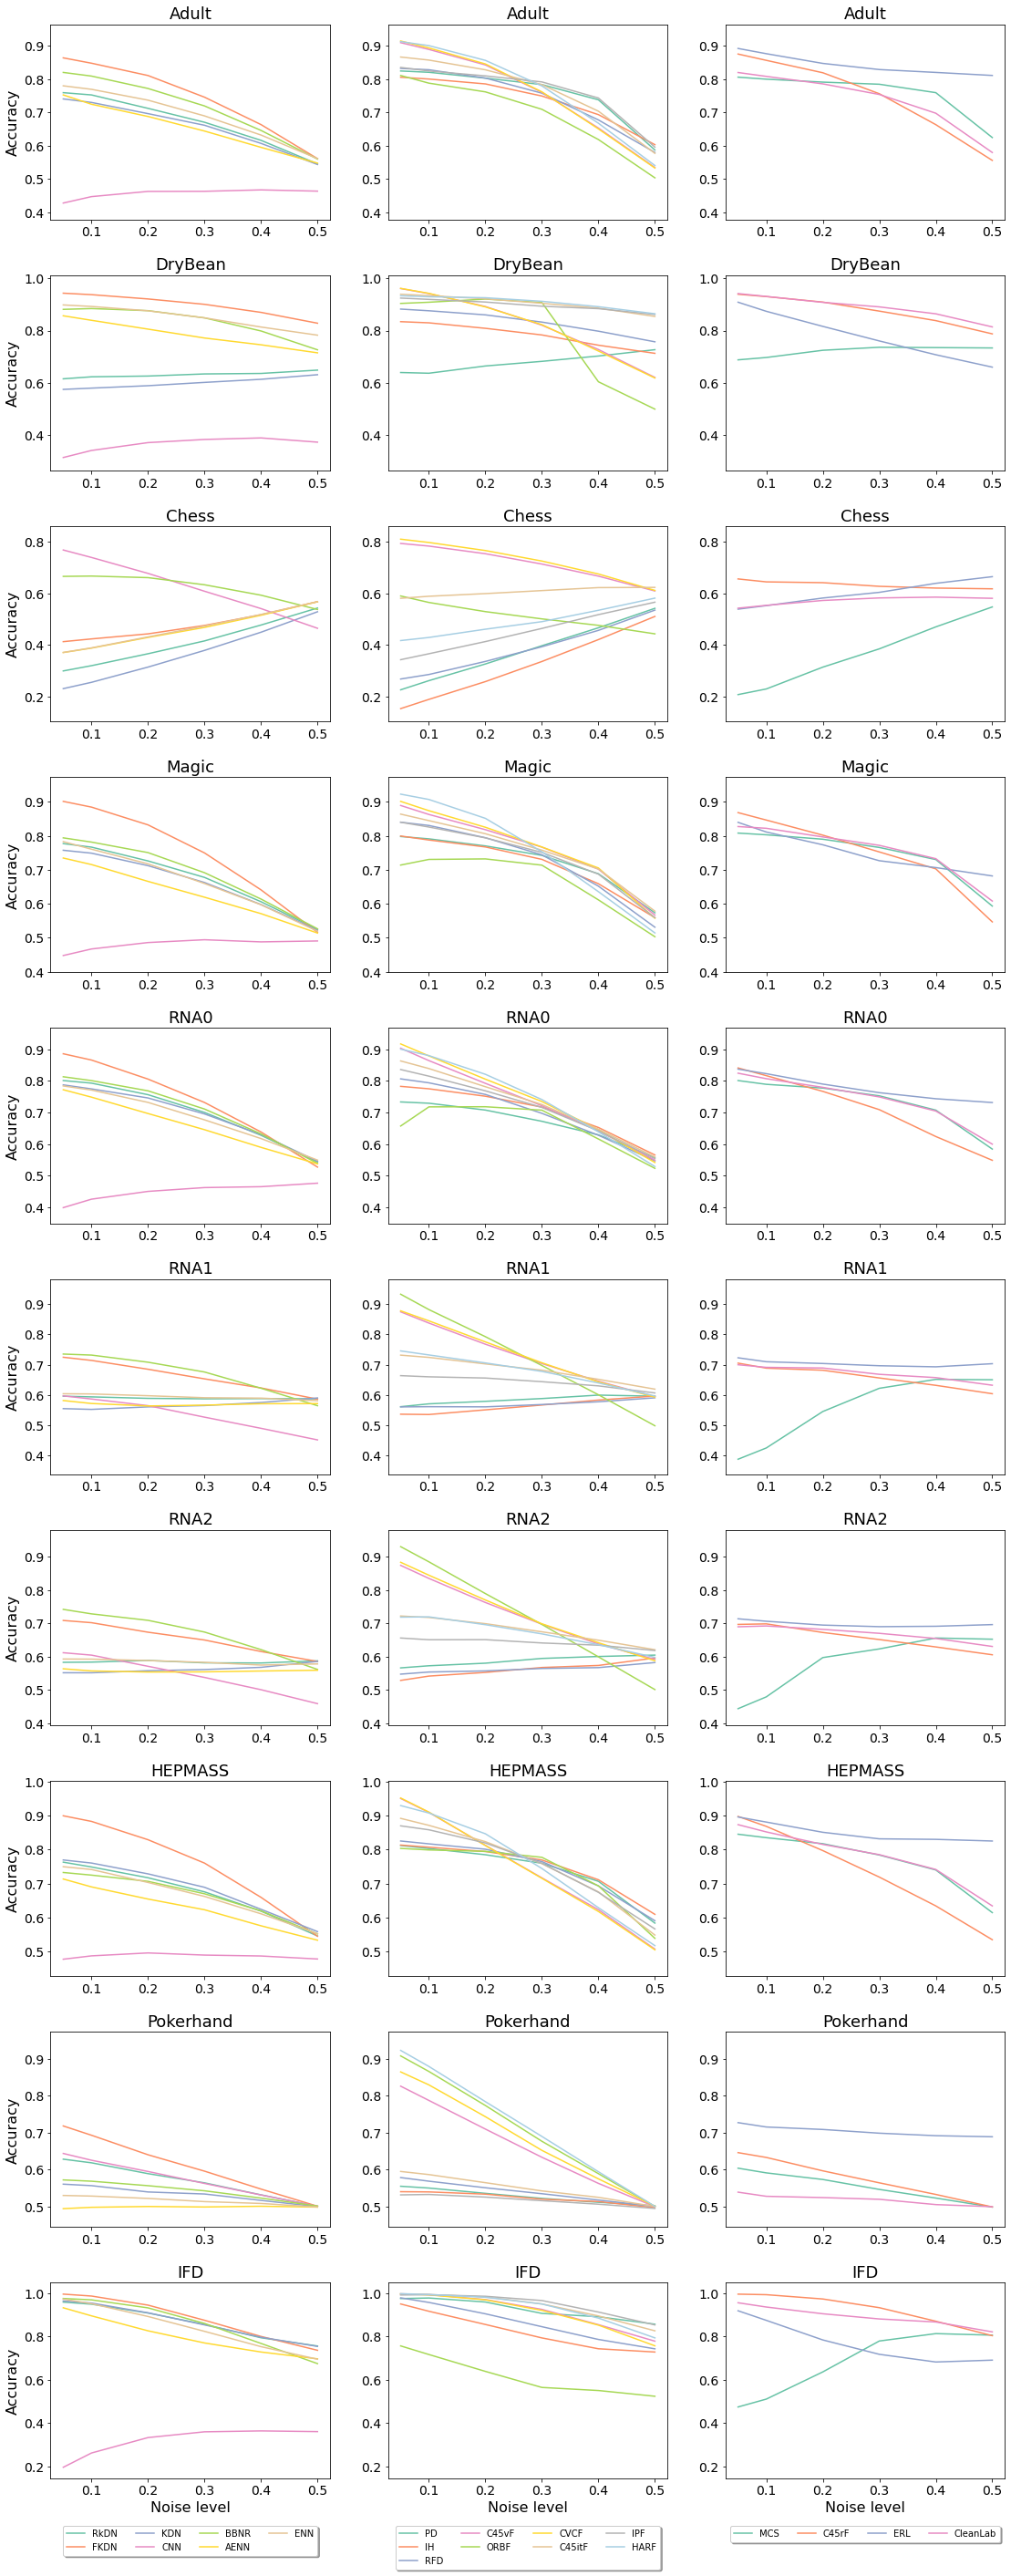

In [82]:

allScores = dfs

di = {'PonOverNoisePerDataset' : [[pon],['NoiseLevel']],
     'PonOverDSPerDataset' : [[pon],['DatasetSize']],

      'RecallOverNoisePerDataset' : [['Recall'],['NoiseLevel']],
      'RecallOverDSPerDataset' : [['Recall'],['DatasetSize']],
      'AccuracyOverDSPerDataset' : [['Accuracy'],['DatasetSize']],
      'AccuracyOverNoisePerDataset' : [['Accuracy'],['NoiseLevel']],
  
}

n = len(datasets)
nn = 3.8*n+2.5
print(nn)
for key in di.keys():
    Score = di[key][0][0]
    variable = di[key][1][0]
    label = labels[variable]
    fig, axs = plt.subplots(n,3,figsize=(16,4*n+2.5))
    fig.set_size_inches(16,3.7*n+2.5, forward=True)


    for j,Dataset in enumerate(datasets[:]):

        scores = allScores[((allScores['Dataset'].str.contains(Dataset)))]
     #   print(len(scores))

        for i,group in enumerate(groups):  
                #print(i)
                models = mod[mod['Group']==group]['Abbreviation']
                lim = scores.groupby(['Model', variable])[Score].mean()
               

                    #plt.figure(figsize=(8,5))
                for model in models[:]:

                    table_ = scores[scores['Model'] == model]

                    if len(table_) > 0:
                        table_ = table_.sort_values([variable])
                        table = pd.DataFrame(table_.groupby(variable).mean(numeric_only = True)).reset_index()
                        axs[j,i].plot(table[variable],table[Score].astype(float),  label = model)

                        if j==n-1: 
                            ncols = 4
                            if group == 'Single':
                                ncols = 4
                            axs[j,i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.22),
                  fancybox=True, shadow=True, ncol=ncols)

                        axs[j,i].set_title("{}".format(Dataset), fontsize = 18 )
                        if j==n-1: 
                            axs[j,i].set_xlabel(label,fontsize = 16 )
                        if i==0:
                            axs[j,i].set_ylabel(Score,fontsize = 16 )
                        #plt.savefig('figures/'+Dataset+Score+noiseType+'.png',transparent=True)
                        axs[j,i].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
                        axs[j,i].set_ylim(lim.min()-0.05,lim.max()+0.05)
                        axs[j,i].tick_params(axis='both', labelsize=14)
                       # axs[j,i].set_xticklabels(table[variable].to_list())




                       

    fig.tight_layout(pad= 2)
  #  plt.subplots_adjust(bottom = 0.15)

  #  plt.savefig('figuresNew/'+Score+'_'+variable+'_'+b+'.png',transparent=False#,bbox_inches = 'tight'
   #             , dpi = 100)


#### Correlation score scores for cost of filtering

In [374]:
a = dfs[['Precision',pon,'Recall','F-score','NoiseLevel','NoiseType','DatasetSize',retrieved, 
         'PLR','PLR-Inv'  ]]

corr = a.corr().round(3)
corr.round(3)
di = {retrieved:'SNR',
     pon:'PON',
     'NoiseLevel':'Noise level',
     'DatasetSize':'Sample size'}
corr.columns = pd.Series(corr.columns).replace(di)
corr.index = pd.Series(corr.index).replace(di)
corr

/data/gpfs-1/scratch/users/nazaretl_c/tmp/ipykernel_703484/3336179345.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = a.corr().round(3)


Precision    PON  Recall  F-score  Noise level  Sample size  \
Precision        1.000  0.780   0.276    0.845        0.532        0.037   
PON              0.780  1.000   0.430    0.720       -0.115        0.043   
Recall           0.276  0.430   1.000    0.646       -0.144        0.104   
F-score          0.845  0.720   0.646    1.000        0.367        0.087   
Noise level      0.532 -0.115  -0.144    0.367        1.000        0.000   
Sample size      0.037  0.043   0.104    0.087        0.000        1.000   
SNR             -0.064 -0.288   0.502    0.183        0.288        0.016   
PLR              0.289  0.389   0.083    0.214       -0.041        0.053   
PLR-Inv         -0.126 -0.091  -0.089   -0.130       -0.079        0.015   

               SNR    PLR  PLR-Inv  
Precision   -0.064  0.289   -0.126  
PON         -0.288  0.389   -0.091  
Recall       0.502  0.083   -0.089  
F-score      0.183  0.214   -0.130  
Noise level  0.288 -0.041   -0.079  
Sample size  0.016  0.053    0.015  
SNR          1.000 -0.167    0.097  
PLR         -0.167  1.000   -0.016  
PLR-Inv      0.097 -0.016    1.000

In [376]:
#corr.to_excel('figuresNew/corr_table.xlsx')

#### Comparison of symmetric, asymmetric noise and real aggregated over datasets 

16
16


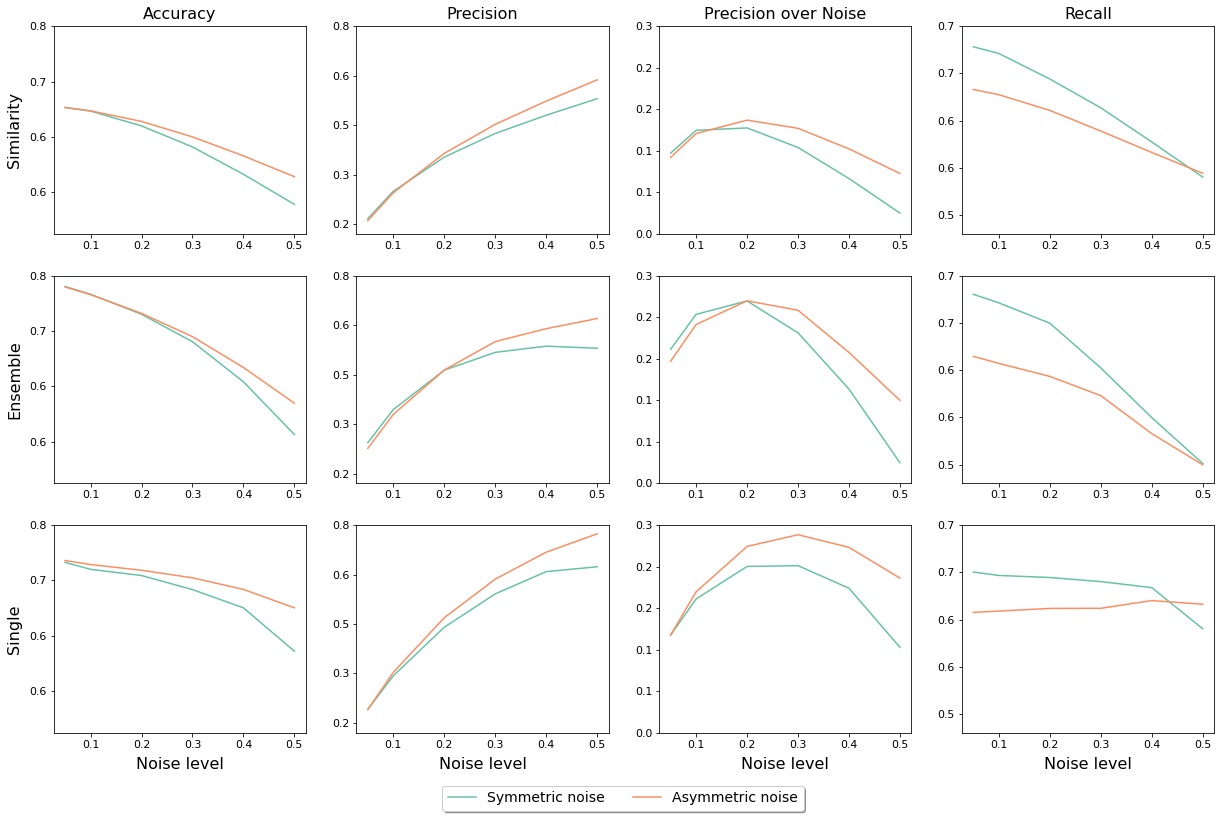

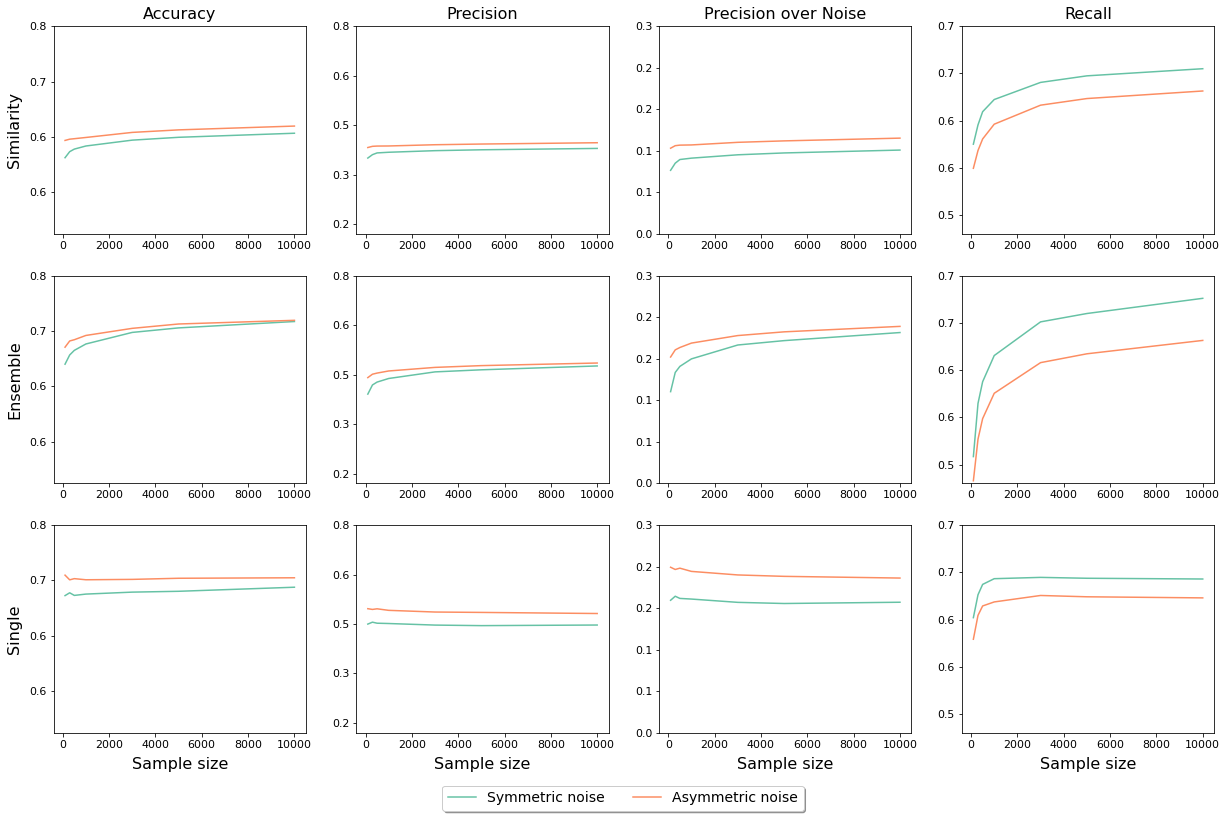

In [379]:

allScores = dfs
clinVarScores = allScores[allScores['Dataset'].isin(['ClinVarReal','ClinVarArt'])]

fs = 14

allNoiseTypes = ["Sym","Asym", "Real"]
twoNoiseTypes = ["Sym","Asym"]


NoiseTypes = allNoiseTypes
n = len(NoiseTypes)


ClinVarLim = [[0.45,0.8],[0,0.9],[-0.2,0.3],[0.2,0.73]]
allLim = [ [0.5,0.8],[0,0.9],[-0.2,0.3],[0.35,0.73]]
allLim = [ [0.5,0.8],[0.12,0.75],[0,0.3],[0.48,0.7]]

diLabels = {'Asym': 'Asymmetric noise',
     'Sym' : 'Symmetric noise'}

scores, variabels = [['Accuracy','Precision',pon, 'Recall'
                     ],['NoiseLevel','NoiseLevel','NoiseLevel','NoiseLevel'
                       ]]

scores1, variabels1 = [['Accuracy','Precision',pon, 'Recall'
                     ],['DatasetSize','DatasetSize','DatasetSize','DatasetSize'
                       ]]

di = {#'NoiseTypeAll': [allScores,allNoiseTypes,ClinVarLim,scores, variabels],
      'NoiseTypeAllW' : [allScores,twoNoiseTypes,allLim,scores, variabels],
      'NoiseTypeAllWS' : [allScores,twoNoiseTypes,allLim,scores1, variabels1],

    #  'NoiseTypeClinVar' :[clinVarScores,allNoiseTypes,ClinVarLim, scores, variabels]
}

n = 1.3
for key in di.keys():
    li = di[key][3]
 
    fig, axs = plt.subplots(3,len(li),figsize=(4*len(li)*n,10*n))
    print(4*len(li))

    for i,Score in enumerate(li):

        scores_raw = di[key][0]
        NoiseTypes = di[key][1]
        lim = di[key][2]
        variable = di[key][4][i]
        for noiseType in NoiseTypes:
            scores_ =scores_raw[scores_raw['NoiseType'] == noiseType]

            for j,group in enumerate(groups): 

                models = mod[mod['Group']==group]['Abbreviation']
                scores = scores_[scores_['Model'].isin(models)]

                table = scores.groupby(variable).mean(numeric_only = True).reset_index()

                if len(table) > 0:

                    if i==0:
                        axs[j,i].set_ylabel(group,fontsize = fs+2, labelpad = 7 )
                    if j ==0:
                        axs[j,i].set_title("{}".format(Score),fontsize = fs+2 , pad = 7)
                    label = diLabels[noiseType]
                    axs[j,i].plot(table[variable],table[Score].astype(float),  label = label)
                    axs[j,i].tick_params(axis='both', which='major', labelsize=fs-3)
#                    axs[j,i].set_ylabel(group,fontsize = fs )

                   

                    if (j ==len(groups)-1) : 
                        axs[j,i].set_xlabel(labels[variable],fontsize = fs+2, labelpad = 7 )

                        if (i ==len(li)-1): 
                            axs[j,i].legend( bbox_to_anchor=(-0.6, -0.22),#loc = 'lower center',
              fancybox=True, shadow=True, ncol=2,fontsize = fs )

                axs[j,i].set_ylim(lim[i])
                axs[j,i].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
                axs[j,i].yaxis.set_major_locator(MaxNLocator(5)) 


  #  fig.tight_layout()

    name = key+ b + '.png'
   # plt.savefig('figuresNew/' + name,transparent=False,bbox_inches = 'tight', dpi = 80)


#### Pivot table (heatmap) of  model performance vs. sample

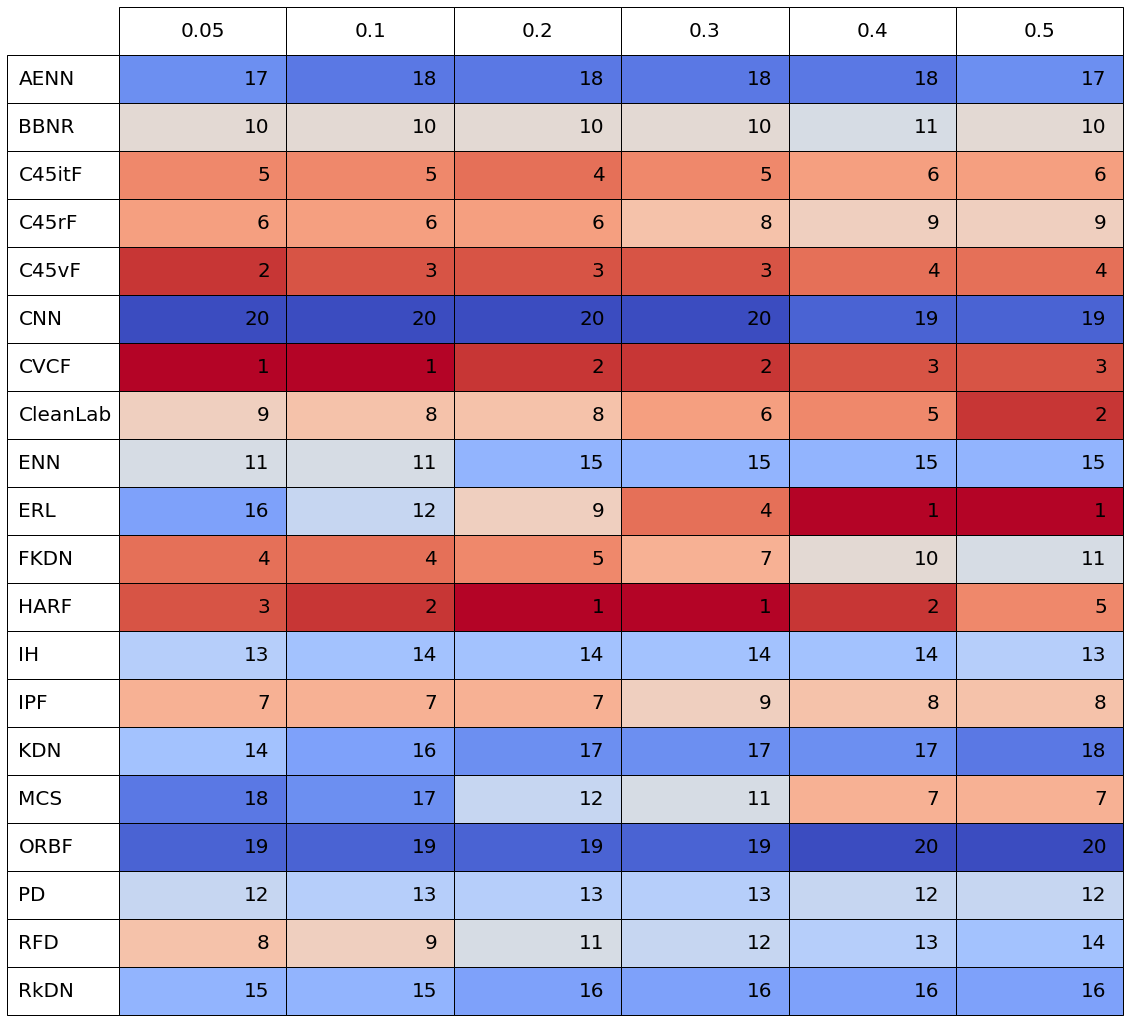

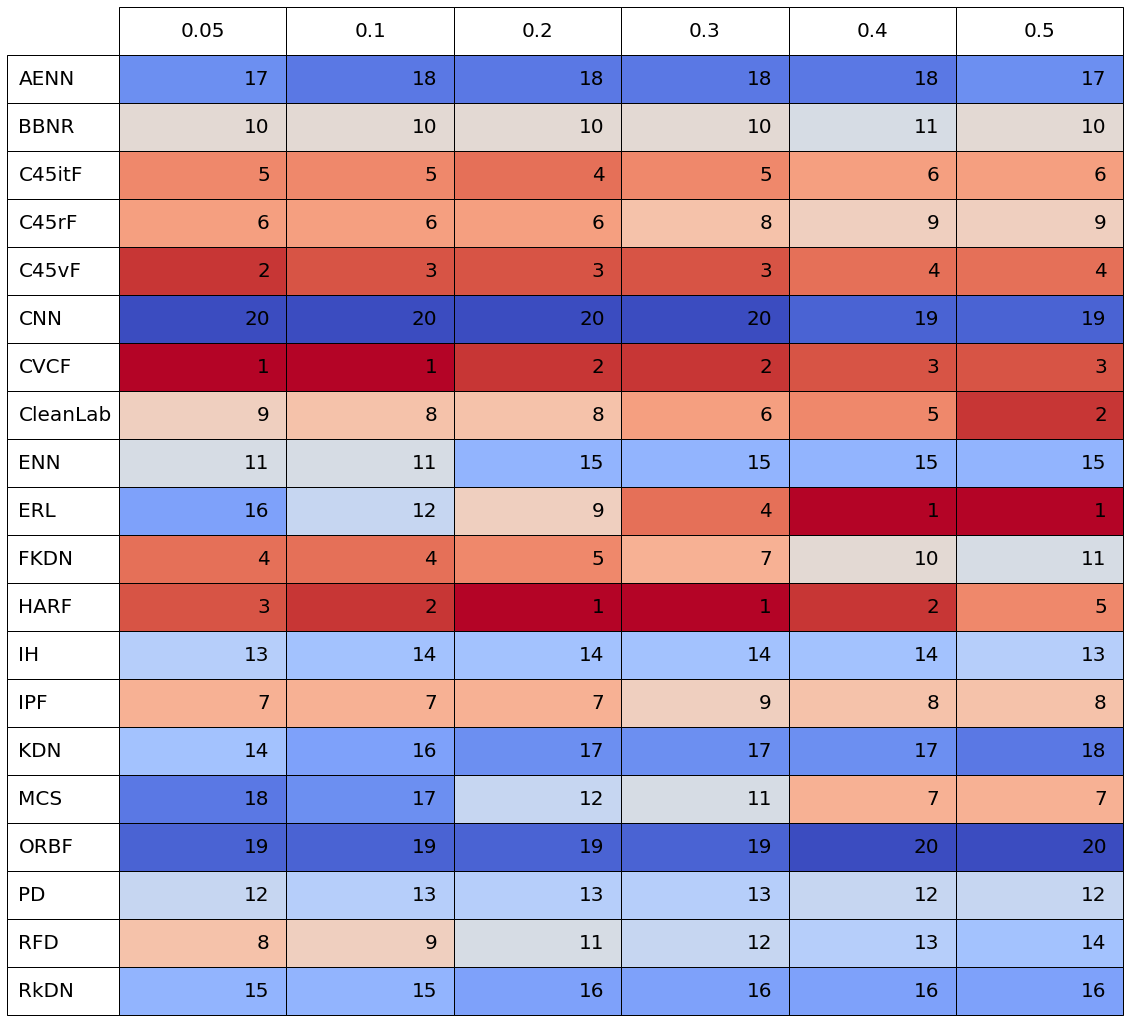

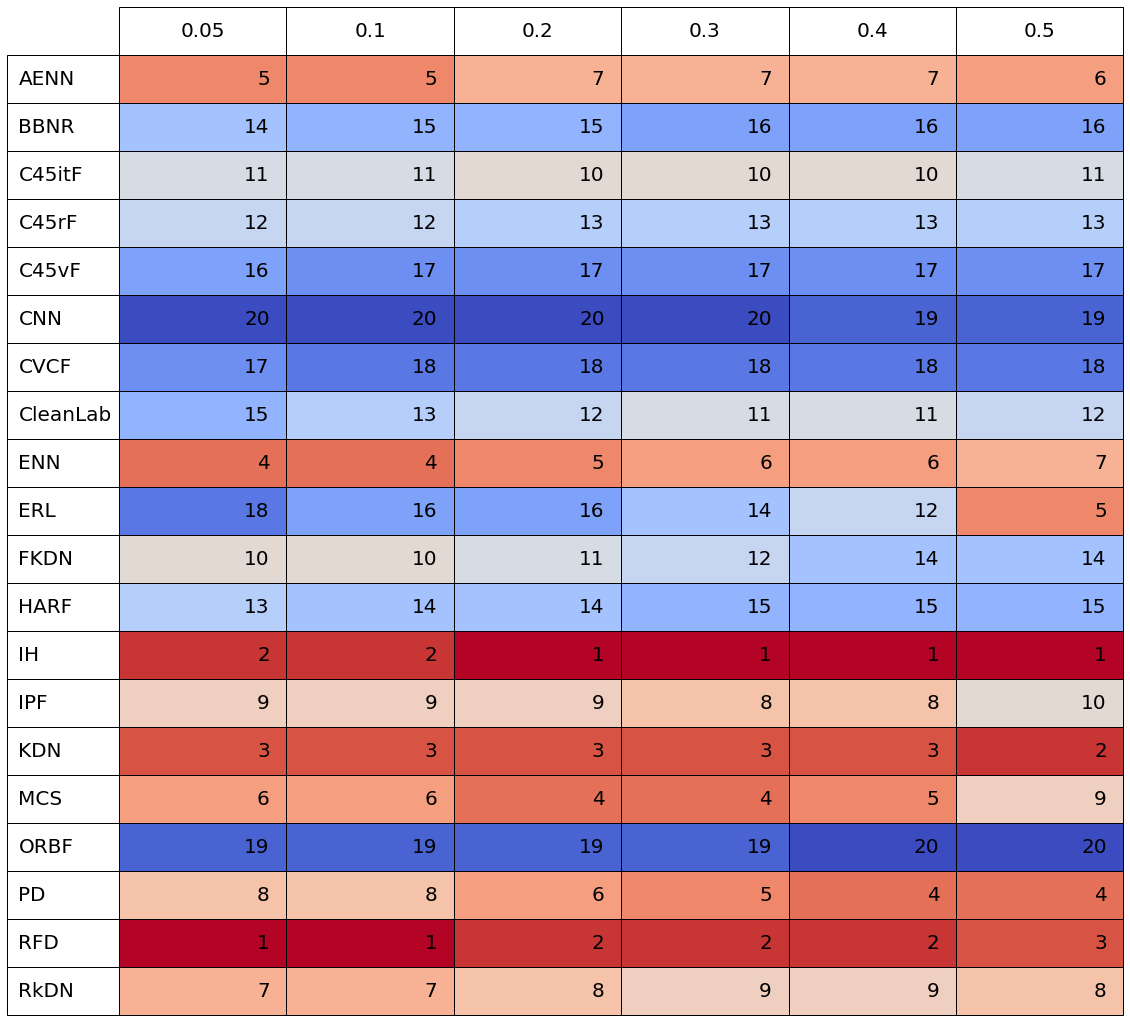

In [380]:
from matplotlib import pyplot as plt
import numpy as np
randn = np.random.randn
from pandas import *


cols = [0.05, 0.1, 0.2, 0.3, 0.4,  0.5, 0.6, 0.7]
cols = [0.05, 0.1, 0.2, 0.3, 0.4,  0.5]

#cols = datasets
Score = pon
variable = 'NoiseLevel'
scores, variables = [['Precision',pon, 'Recall'],['NoiseLevel','NoiseLevel','NoiseLevel']]

for i, Score in enumerate(scores):
    variable = variables[i]

    df = allScores.pivot_table(values=Score, index='Model', columns=variable, aggfunc='mean')
    df = df.rank(ascending = False)
    #df.columns = cols
    df= df.astype(float).round(4)
    df= df.astype(int)

    vals = df.values# np.around(df.values,4)
    Min=vals.astype(float).min().min()
    Max=vals.astype(float).max().max()
    norm = plt.Normalize(Min-1, Max+1)
    #norm = plt.Normalize(0, 1)
    cmap = plt.get_cmap('coolwarm_r')

    colours = cmap(norm(vals))

    colores = np.zeros((vals.shape[0], vals.shape[1], 4))
    #cmap = plt.get_cmap('viridis')
    #cmap = plt.get_cmap('hot')

    for i in range(vals.shape[1]):
        col_data = pd.Series(vals[:, i])
        #normal = plt.Normalize(np.min(col_data), np.max(col_data))
        #colores[:, i]  = cmap(norm(col_data))
        a = ((col_data -col_data.min())/(col_data.max() - col_data.min())).to_numpy()
        a = np.ma.masked_array(a)
        colores[:, i] = cmap(a)


    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(111, frameon=False, xticks=[], yticks=[])

    ytable=plt.table(cellText=vals, rowLabels=df.index, colLabels=df.columns, 
                        colWidths = [0.2]*vals.shape[1]
                      #  colHeights = [0.2]*vals.shape[0]
                        , loc='center', 
                        cellColours=colores)
    ytable.set_fontsize(20)
    ytable.scale(1, 4)
   # fig.tight_layout()

#    plt.savefig('figuresNew/ModelvsDataset'+Score+'_'+b+'.png',transparent=False,bbox_inches = 'tight'                   )

    plt.show()


#### Pivot table (heatmap) of  model performance vs. all averaged scores

Accuracy
Precision
Precision over Noise
Recall
F-score


/data/gpfs-1/scratch/users/nazaretl_c/tmp/ipykernel_703484/3976876551.py:79: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


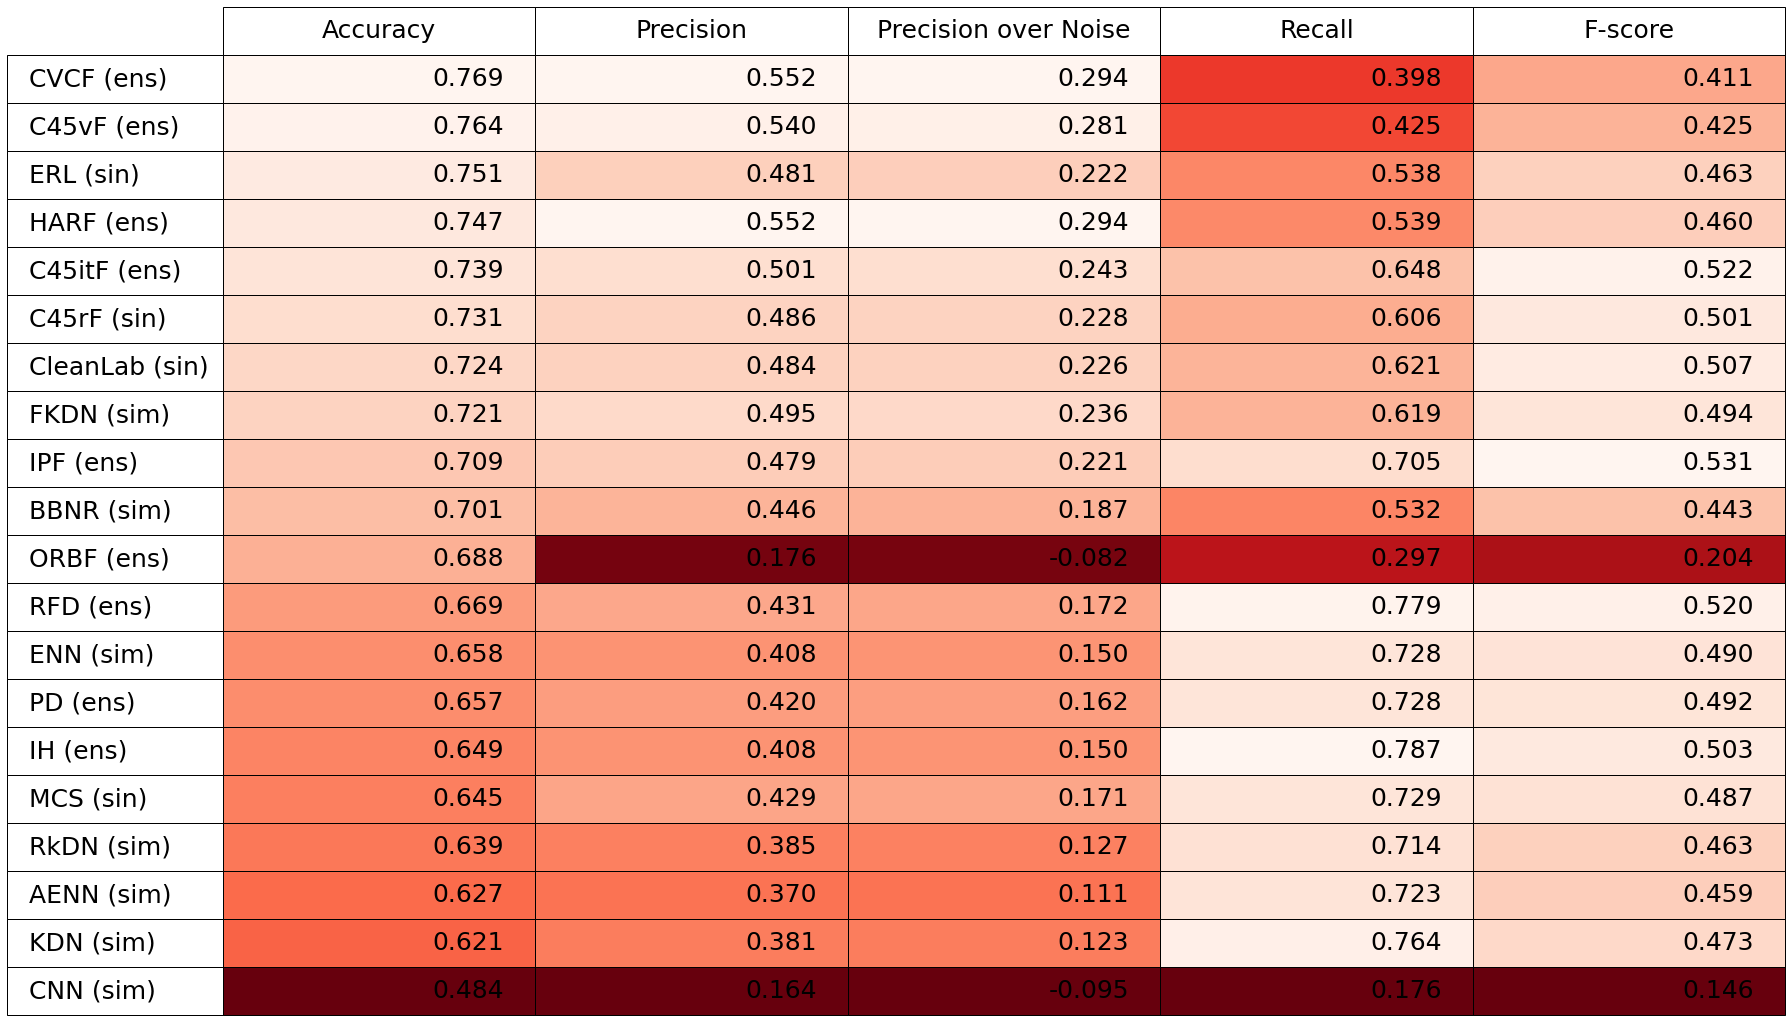

In [386]:

import matplotlib.cm as cm
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

a = dfs#[dfs['Group'] =='Ensemble']
columns=['Accuracy','Precision',pon,'Recall','F-score',
         ]

n = round(len(dfs)*0.7)
li = []
for i in range(100):
    dfs_sample = dfs.sample(n = n)
    a = dfs_sample.groupby(['Model']).mean(numeric_only = True)#.reset_index()
    li.append(a[columns])
ind = a.index

means = pd.DataFrame(np.mean(np.array(li),axis = 0))
means.index = a.index
means.columns = columns

#means = a.groupby('Model').mean()

means['Group'] = means.index
means['Group'] = means['Group'].replace(di)

#means = means.sort_values(['Group','Accuracy'], ascending = True)
means = means.sort_values(['Accuracy'], ascending = False)


fig, ax = plt.subplots(figsize=(28,4))




rows = means.index.to_list()
rows = pd.Series(rows) + ' (' + pd.Series(rows).replace(diSave).str[0:3].str.lower() + ')'

conf_data = means[columns].round(3).to_numpy()

#conf_data = pd.DataFrame(conf_data)#.sort_values(4, ascending = False).to_numpy()
conf_data = pd.DataFrame(conf_data).to_numpy()

colores = np.zeros((conf_data.shape[0], conf_data.shape[1], 4))
cmap = plt.get_cmap('viridis')

cmap = plt.get_cmap('Reds').reversed()

for i in range(conf_data.shape[1]):
    print(columns[i])
    
    col_data = pd.Series(conf_data[:, i])
    normal = plt.Normalize(np.min(col_data), np.max(col_data))
    #colores[:, i]  = cmap(norm(col_data))
    a = ((col_data -col_data.min())/(col_data.max() - col_data.min())).to_numpy()
    a = np.ma.masked_array(a)
    if columns[i] in  ['Execution Time','PLR-Inv' ]:
        colores[:, i] =  cmap.reversed()(a)
    else:
        colores[:, i] = cmap(a)


#col_data = pd.Series(conf_data[:, 0])
#a = ((col_data -col_data.min())/(col_data.max() - col_data.min())).to_numpy()
#colores[:, 0] = cmap(a)


ax.axis('off')
ax.axis('tight')
conf_data = [['%.3f' % j for j in i] for i in conf_data]
table = ax.table(cellText=conf_data#.round(3)
                 ,
         rowLabels=rows,
         colLabels=columns,
         cellColours=colores,
         loc='center',
         colWidths=[0.2]*len(columns),
        )
table.set_fontsize(34)
table.scale(1, 4)
fig.tight_layout()
#plt.savefig('figuresNew/heatmap_table_means_over_everything'+b+'.png',transparent=False,bbox_inches = 'tight'                   )

plt.show()